# Group Assignment QF627

<font size = 5>**Group Members:**</font>
* Anna Germaine Lim
* Chen Pengyu
* Gregory Tan
* Zenith Tay

# Contribution Statement

Name        |Work Contributed                                                                           |
---         |   ---                                                                                     |
Zenith      |Supervised Learning Models and Codes, Report Writing, Team Reflections                           |
Gregory     |   Momentum Trading Strategies and Codes, Report Writing and Collation, Team Reflections             |
Anna        |Mean-Reversion Strategies and Codes, Report Writing, Team Reflections                                |
Pengyu      |Report Writing, Team Reflections, Attempts on unsupervised learning                        |

# Prep Work

## Packages Used in This Workbook

In [ ]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as pdr

## For Visualisation

In [ ]:
### For Supervised learning

# Model specification

# linear models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.linear_model import ElasticNet # Elastic Net
from sklearn.linear_model import Lasso # LASSO

# oldies
from sklearn.svm import SVR # Support Vector Machine
from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbor

# decision tree
from sklearn.tree import DecisionTreeRegressor# Decision Tree

# bagging
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees

# boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Tree
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting

# time-series
import statsmodels.tsa.arima.model as stats # ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Data split
from sklearn.model_selection import train_test_split

# feature engineering

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

## Functions

### Download of Data

In [ ]:
start_date = "2006-11-01"
end_date = "2025-11-13"

In [ ]:
def download_data (ticker: list[str] | str,
                   start_date = start_date, 
                   end_date = end_date,
                   close_only = False) -> pd.DataFrame:
    if close_only == False:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
        )
    else:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
                        ["Close"]
        )    

    return data

In [ ]:
# preallocate empty array and assign slice

def np_shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

### Performance Metrics

In [ ]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

In [ ]:
## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

In [ ]:
### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd


### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

In [ ]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

In [ ]:
def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    final_equity = cum_returns_series.iloc[-1] * 1e5
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}',
            f'Final Equity: {final_equity: .4f}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD, final_equity])

## Download Dataset

In [ ]:
spy_data =\
(
    download_data("SPY", start_date, end_date)
)
spy_data

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2006-11-01   95.973610   96.990426   95.875435   96.927316   83005600
2006-11-02   95.917511   96.078796   95.622986   95.728169   60693100
2006-11-03   95.749184   96.345254   95.104031   96.261107   71346400
2006-11-06   96.829170   96.969419   96.036750   96.043769   63303300
2006-11-07   97.200806   97.460266   96.773040   96.913289   63318900
...                ...         ...         ...         ...        ...
2025-11-06  670.309998  677.380005  668.719971  676.469971   85035300
2025-11-07  670.969971  671.080017  661.210022  667.909973  100592400
2025-11-10  681.440002  682.179993  675.030029  677.239990   75842900
2025-11-11  683.000000  683.570007  678.729980  679.950012   58953400
2025-11-12  683.380005  684.960022  680.950012  684.789978   62312500

[4788 rows x 5 columns]

In [ ]:
spy_data = \
    (
        spy_data
        .droplevel(
            level = 1,
            axis =1
        )
    )

# Part 1 and 2: Analysis, Visualisation and Strategy

## Project Start

Data Wrangling and Preparation

In [ ]:
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))
spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [11]:
len(spy_train_data) + len(spy_test_data)

4788

## (1A) Momentum Trading Strategy

### Functions to Generate Positions and Signals

In [ ]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [ ]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [ ]:
def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [ ]:
## Rate of Change

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

In [ ]:
def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [ ]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [ ]:
def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [ ]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

In [ ]:
def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Functions to Generate Metrics

In [ ]:

def calculate_stats(price_data: pd.DataFrame,
                     price_col: str = "Close",
                     return_period: int = 1,
                     initial_capital: float = 1e5):

    price_series = price_data[price_col]
    log_price = np.log(price_series)

    if return_period == 1:
        # 1‑day log returns
        strategy_returns = log_price.diff().dropna()
    else:
        # non‑overlapping return_period‑day log returns
        strategy_returns = (
            log_price
            .diff(return_period)
            .iloc[::return_period]
            .dropna()
        )


    equity_curve =\
      (
            np.exp(strategy_returns.cumsum())
            * initial_capital
      )

    periods_per_year = (252 / return_period)

    mean_return = strategy_returns.mean()
    std_return = strategy_returns.std()

    sharpe =\
      (
            mean_return
            / std_return
            * np.sqrt(periods_per_year)
      )

    n_periods = strategy_returns.shape[0]
    years = n_periods / periods_per_year

    final_equity = equity_curve.iloc[-1]

    cagr = (
        (final_equity / initial_capital) ** (1 / years)
        - 1
    )

    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1
    max_drawdown = drawdown.min()

    results = {
        "sharpe": f"{sharpe:.2f}",
        "cagr": f"{cagr * 100:.2f}%",
        "max_drawdown": f"{max_drawdown * 100:.2f}%",
        "final_equity": f"{final_equity:.2f}"
    }

    return results

In [ ]:
spy_train_stats = calculate_stats(spy_train_data[["Close"]])
spy_train_stats

{'sharpe': '0.46',
 'cagr': '9.84%',
 'max_drawdown': '-55.19%',
 'final_equity': '380947.47'}

In [ ]:
spy_test_stats = calculate_stats(spy_test_data[["Close"]])
spy_test_stats


{'sharpe': '0.77',
 'cagr': '14.10%',
 'max_drawdown': '-24.50%',
 'final_equity': '187040.08'}

### FI Train (No Luck)
FI Signals attempted to include volume to indicate strength of the turn. However for indication of trends, not very useful

In [ ]:
time_periods = np.arange(10, 201, 10).tolist()

In [ ]:
def generate_fi_Metrics(df,
                        time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:

        data = df.copy()

        data["Returns"] = data["Close"].pct_change()
        
        data[f'fi{i}'] = generate_force_index(df['Close'], df['Volume'], i)
        
        data = pd.concat([data, generate_force_index_signal(data[f'fi{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['FI_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'FI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)', 'Final Equity']
    return Metrics.T

In [ ]:
generate_fi_Metrics(spy_test_data,time_periods).sort_values(by = 'Final Equity', ascending=False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
FI180      -0.015838 -0.003349          -0.019370      0.224752   
FI100      -0.036628 -0.007811          -0.045174      0.245240   
FI130      -0.101994 -0.022352          -0.129278      0.270469   
FI30       -0.110180 -0.024232          -0.140148      0.221187   
FI110      -0.111255 -0.024479          -0.141582      0.296811   
FI90       -0.111711 -0.024585          -0.142191      0.238449   
FI190      -0.123984 -0.027432          -0.158661      0.281704   
FI200      -0.139837 -0.031157          -0.180207      0.274162   
FI40       -0.141399 -0.031527          -0.182346      0.288792   
FI120      -0.155842 -0.034974          -0.202281      0.297119   
FI170      -0.159693 -0.035900          -0.207641      0.298132   
FI140      -0.171346 -0.038725          -0.223983      0.342874   
FI160      -0.187041 -0.042580          -0.246282      0.335115   
FI150      -0.190092 -0.043336          -0.250657      0.339476   
FI10       -0.191496 -0.043685          -0.252673      0.270142   
FI20       -0.203463 -0.046677          -0.269983      0.293958   
FI80       -0.247470 -0.057994          -0.335464      0.329013   
FI70       -0.279393 -0.066535          -0.384893      0.356971   
FI50       -0.313523 -0.076004          -0.439705      0.390297   
FI60       -0.341426 -0.084027          -0.486154      0.417506   

       Longest Drawdown (Days)  Final Equity  
FI180                    649.0  98416.220046  
FI100                    510.0  96337.168964  
FI130                   1139.0  89800.623948  
FI30                     649.0  88982.038238  
FI110                    536.0  88874.510604  
FI90                    1158.0  88828.858667  
FI190                   1139.0  87601.556910  
FI200                   1139.0  86016.278293  
FI40                    1139.0  85860.131063  
FI120                   1139.0  84415.763126  
FI170                   1139.0  84030.747026  
FI140                   1139.0  82865.384381  
FI160                   1139.0  81295.923517  
FI150                   1139.0  80990.773601  
FI10                    1139.0  80850.420845  
FI20                    1184.0  79653.685941  
FI80                    1714.0  75252.981920  
FI70                    1714.0  72060.707097  
FI50                    1714.0  68647.735091  
FI60                    1714.0  65857.359741

In [ ]:
generate_fi_Metrics(spy_train_data,time_periods).sort_values(by = 'Final Equity', ascending=False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
FI50       -0.532210 -0.051805          -0.252649      0.683662   
FI10       -0.560233 -0.055897          -0.272611      0.664629   
FI20       -0.634299 -0.068010          -0.331704      0.699975   
FI80       -0.634973 -0.068130          -0.332292      0.756666   
FI40       -0.646116 -0.070151          -0.342150      0.698738   
FI60       -0.687794 -0.078273          -0.381784      0.772906   
FI30       -0.693552 -0.079474          -0.387642      0.722372   
FI70       -0.734089 -0.088574          -0.432054      0.823662   
FI90       -0.737446 -0.089384          -0.436010      0.805538   
FI100      -0.773133 -0.098651          -0.481252      0.829513   
FI110      -0.784629 -0.101927          -0.497247      0.842879   
FI180      -0.796146 -0.105376          -0.514091      0.853327   
FI120      -0.805951 -0.108459          -0.529143      0.853254   
FI170      -0.809571 -0.109633          -0.534882      0.867467   
FI160      -0.813642 -0.110980          -0.541457      0.870572   
FI190      -0.819995 -0.113136          -0.551990      0.866266   
FI150      -0.832318 -0.117529          -0.573449      0.881329   
FI140      -0.839260 -0.120137          -0.586195      0.886660   
FI130      -0.839532 -0.120242          -0.586705      0.881942   
FI200      -0.855338 -0.126606          -0.617805      0.893204   

       Longest Drawdown (Days)  Final Equity  
FI50                    3874.0  46778.992561  
FI10                    4766.0  43976.692967  
FI20                    5157.0  36570.125630  
FI80                    3472.0  36502.656052  
FI40                    4463.0  35388.431496  
FI60                    3643.0  31220.608374  
FI30                    5102.0  30644.814207  
FI70                    4354.0  26591.111356  
FI90                    4354.0  26255.415634  
FI100                   4354.0  22686.685511  
FI110                   4354.0  21537.121661  
FI180                   4354.0  20385.367966  
FI120                   4354.0  19404.934492  
FI170                   4354.0  19042.884962  
FI160                   4354.0  18635.763472  
FI190                   4354.0  18000.491011  
FI150                   4354.0  16768.174203  
FI140                   4354.0  16073.980086  
FI130                   4354.0  16046.776220  
FI200                   4354.0  14466.196131

### ROC (No Luck)
ROC Signals Significantly Underperformed the Market

In [ ]:
def generate_ROC_Metrics(df, time_periods):

    ROC_Metrics = pd.DataFrame()

    for i in time_periods:
        roc_data = df.copy()

        roc_data["Returns"] = roc_data["Close"].pct_change()
        
        roc_data[f'ROC{i}'] = generate_rate_of_change(df['Close'], i)
        roc_data = pd.concat([roc_data, generate_rate_of_change_signal(roc_data[f'ROC{i}'])], axis = 1)
        roc_data['Strat_returns'] = roc_data['Returns'] * roc_data['ROC_Position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        roc_series = evaluate_returns(roc_data['Strat_returns'])
        roc_series.name = f'ROC{i}'
        
        ROC_Metrics = pd.concat([ROC_Metrics, roc_series], axis = 1)

    ROC_Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)', 'Final Equity']
    return ROC_Metrics.T

In [ ]:
spy_train_stats

{'sharpe': '0.46',
 'cagr': '9.84%',
 'max_drawdown': '-55.19%',
 'final_equity': '380947.47'}

In [ ]:
generate_ROC_Metrics(spy_train_data, time_periods).sort_values(by = 'Final Equity', ascending=False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
ROC60        1.914912  0.077784           0.683276      0.163699   
ROC180       1.865900  0.076505           0.612807      0.237335   
ROC110       1.844060  0.075929           0.647948      0.230056   
ROC40        1.705084  0.072161           0.634302      0.338357   
ROC150       1.588620  0.068863           0.568325      0.290580   
ROC120       1.567890  0.068261           0.582081      0.213191   
ROC20        1.500402  0.066271           0.597104      0.266625   
ROC190       1.448509  0.064706           0.515824      0.292318   
ROC100       1.370116  0.062283           0.528624      0.237622   
ROC50        1.317382  0.060611           0.537714      0.242890   
ROC130       1.265837  0.058942           0.499438      0.267799   
ROC140       1.256902  0.058649           0.490542      0.255147   
ROC30        1.245860  0.058286           0.520816      0.287064   
ROC200       1.226990  0.057660           0.456852      0.336411   
ROC170       1.190488  0.056437           0.460437      0.241159   
ROC80        1.160491  0.055418           0.489381      0.283963   
ROC160       1.092155  0.053045           0.436564      0.265807   
ROC90        1.081205  0.052659           0.461410      0.269074   
ROC70        0.843182  0.043745           0.380886      0.316274   
ROC10        0.695235  0.037648           0.317482      0.453508   

        Longest Drawdown (Days)   Final Equity  
ROC60                     860.0  291491.196128  
ROC180                    746.0  286590.040512  
ROC110                    601.0  284405.971776  
ROC40                    1205.0  270508.377363  
ROC150                    707.0  258862.033108  
ROC120                   1005.0  256789.048660  
ROC20                     864.0  250040.161165  
ROC190                    907.0  244850.884383  
ROC100                    879.0  237011.589383  
ROC50                    1023.0  231738.163726  
ROC130                   1049.0  226583.712696  
ROC140                    886.0  225690.195183  
ROC30                    1318.0  224585.952888  
ROC200                   1035.0  222699.004710  
ROC170                    736.0  219048.824637  
ROC80                    1109.0  216049.056777  
ROC160                   1056.0  209215.466031  
ROC90                     936.0  208120.516754  
ROC70                    1300.0  184318.244485  
ROC10                    4178.0  169523.498879

In [ ]:
spy_test_stats

{'sharpe': '0.77',
 'cagr': '14.10%',
 'max_drawdown': '-24.50%',
 'final_equity': '187040.08'}

In [ ]:
generate_ROC_Metrics(spy_test_data, time_periods).sort_values(by = 'Final Equity', ascending=False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
ROC20        0.657700  0.112053           1.042574      0.133363   
ROC160       0.598181  0.103541           0.923522      0.150489   
ROC90        0.563924  0.098528           0.921623      0.128319   
ROC180       0.559810  0.097920           0.851060      0.176522   
ROC10        0.554519  0.097136           0.921546      0.134607   
ROC100       0.551648  0.096710           0.873670      0.135609   
ROC60        0.545116  0.095738           0.870854      0.202772   
ROC50        0.525111  0.092742           0.817091      0.210845   
ROC130       0.522098  0.092288           0.833365      0.181293   
ROC110       0.504500  0.089622           0.824794      0.223593   
ROC70        0.453995  0.081832           0.775051      0.269714   
ROC190       0.451141  0.081385           0.717626      0.203795   
ROC170       0.440258  0.079676           0.682283      0.214537   
ROC30        0.432139  0.078394           0.724941      0.184263   
ROC40        0.378331  0.069751           0.637354      0.231499   
ROC150       0.373204  0.068914           0.610184      0.186358   
ROC140       0.354958  0.065913           0.583649      0.246954   
ROC80        0.338213  0.063132           0.575414      0.226219   
ROC120       0.304421  0.057433           0.530415      0.243812   
ROC200       0.279468  0.053150           0.446017      0.209384   

        Longest Drawdown (Days)   Final Equity  
ROC20                     377.0  165769.991554  
ROC160                    714.0  159818.059395  
ROC90                     528.0  156392.400396  
ROC180                    709.0  155981.034461  
ROC10                     574.0  155451.869904  
ROC100                    543.0  155164.766417  
ROC60                     767.0  154511.616917  
ROC50                     760.0  152511.101182  
ROC130                    697.0  152209.776562  
ROC110                    760.0  150449.992017  
ROC70                     896.0  145399.522555  
ROC190                    746.0  145114.053798  
ROC170                    750.0  144025.764917  
ROC30                     792.0  143213.911876  
ROC40                     919.0  137833.098824  
ROC150                    746.0  137320.366236  
ROC140                    756.0  135495.830432  
ROC80                     990.0  133821.328044  
ROC120                    780.0  130442.100178  
ROC200                    750.0  127946.825193

### RSI (No Luck Either)

In [ ]:
def generate_RSI_Metrics(df, time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:
        data = df.copy()

        data["Returns"] = df["Close"].pct_change()
        
        data[f'RSI{i}'] = generate_RSI(df['Close'], i)
        
        data = pd.concat([data, generate_rsi_signal(data[f'RSI{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['rsi_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'RSI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)', 'Final Equity']
    return Metrics.T

In [ ]:
generate_RSI_Metrics(spy_train_data, range(10, 252, 10)).sort_values(by = 'Final Equity', ascending = False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
RSI200       0.438888  0.025805           0.125855      0.526851   
RSI210       0.314529  0.019333           0.094288      0.533675   
RSI60        0.253294  0.015934           0.077710      0.338981   
RSI100       0.217660  0.013884           0.067713      0.446218   
RSI110       0.200091  0.012853           0.062683      0.529014   
RSI90        0.193689  0.012474           0.060834      0.459147   
RSI190       0.177800  0.011524           0.056203      0.532689   
RSI80        0.154134  0.010088           0.049196      0.411369   
RSI30        0.133981  0.008842           0.043124      0.332984   
RSI170       0.131196  0.008669           0.042277      0.531112   
RSI160       0.130843  0.008647           0.042170      0.567017   
RSI150       0.125431  0.008308           0.040517      0.549105   
RSI180       0.107585  0.007180           0.035017      0.522970   
RSI50        0.078687  0.005318           0.025933      0.391090   
RSI140       0.075732  0.005124           0.024991      0.499438   
RSI120       0.041009  0.002818           0.013743      0.503341   
RSI130      -0.019860 -0.001404          -0.006845      0.512818   
RSI70       -0.051685 -0.003709          -0.018087      0.430766   
RSI220      -0.073771 -0.005351          -0.026097      0.609988   
RSI20       -0.123961 -0.009224          -0.044981      0.419470   
RSI40       -0.161502 -0.012257          -0.059776      0.510479   
RSI230      -0.246504 -0.019622          -0.095691      0.667284   
RSI10       -0.378082 -0.032708          -0.159507      0.627660   
RSI240      -0.389797 -0.033995          -0.165784      0.697269   
RSI250      -0.489989 -0.046050          -0.224582      0.758971   

        Longest Drawdown (Days)   Final Equity  
RSI200                   3242.0  143888.833170  
RSI210                   3895.0  131452.931194  
RSI60                    1202.0  125329.359225  
RSI100                   3206.0  121765.976691  
RSI110                   3245.0  120009.092822  
RSI90                    3227.0  119368.884577  
RSI190                   3892.0  117779.997363  
RSI80                    2261.0  115413.383033  
RSI30                    2069.0  113398.127728  
RSI170                   3186.0  113119.581265  
RSI160                   3228.0  113084.336722  
RSI150                   3203.0  112543.101552  
RSI180                   3482.0  110758.504827  
RSI50                    1282.0  107868.701948  
RSI140                   3060.0  107573.158739  
RSI120                   3228.0  104100.914539  
RSI130                   3242.0   98013.961637  
RSI70                    3147.0   94831.527347  
RSI220                   4354.0   92622.862319  
RSI20                    3472.0   87603.862026  
RSI40                    3472.0   83849.767258  
RSI230                   4354.0   75349.609730  
RSI10                    5211.0   62191.808707  
RSI240                   5211.0   61020.318949  
RSI250                   5211.0   51001.077864

In [ ]:
generate_RSI_Metrics(spy_test_data, range(10, 252, 10)).sort_values(by = 'Final Equity', ascending = False)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
RSI40        0.272516  0.051945           0.300521      0.236088   
RSI60        0.152489  0.030272           0.175106      0.330249   
RSI50        0.151113  0.030013           0.173611      0.288491   
RSI20        0.101579  0.020537           0.118790      0.326224   
RSI30        0.076415  0.015594           0.090194      0.404380   
RSI70        0.066659  0.013652           0.078966      0.351427   
RSI90       -0.022112 -0.004688          -0.027111      0.406185   
RSI80       -0.067349 -0.014545          -0.084121      0.443804   
RSI100      -0.145357 -0.032467          -0.187783      0.418557   
RSI110      -0.171180 -0.038685          -0.223748      0.436199   
RSI240      -0.214819 -0.049549          -0.286599      0.470406   
RSI120      -0.219006 -0.050616          -0.292775      0.494437   
RSI10       -0.219008 -0.050617          -0.292777      0.326671   
RSI130      -0.246450 -0.057726          -0.333912      0.518623   
RSI250      -0.251900 -0.059162          -0.342221      0.498144   
RSI170      -0.281382 -0.067077          -0.388030      0.531109   
RSI150      -0.307250 -0.074237          -0.429472      0.558685   
RSI140      -0.308524 -0.074595          -0.431543      0.581781   
RSI160      -0.316292 -0.076789          -0.444247      0.553887   
RSI230      -0.339924 -0.083588          -0.483614      0.554788   
RSI180      -0.379734 -0.095489          -0.552545      0.579816   
RSI200      -0.390961 -0.098954          -0.572622      0.566117   
RSI220      -0.394020 -0.099907          -0.578143      0.590170   
RSI190      -0.400557 -0.101956          -0.590016      0.576807   
RSI210      -0.446079 -0.116737          -0.675705      0.617426   

        Longest Drawdown (Days)   Final Equity  
RSI40                     887.0  127251.642293  
RSI60                    1023.0  115248.871626  
RSI50                     876.0  115111.306321  
RSI20                    1582.0  110157.851671  
RSI30                    1532.0  107641.461108  
RSI70                    1191.0  106665.881997  
RSI90                    1409.0   97788.823005  
RSI80                    1409.0   93265.055239  
RSI100                   1714.0   85464.253258  
RSI110                   1714.0   82882.042216  
RSI240                   1714.0   78518.093915  
RSI120                   1714.0   78099.382745  
RSI10                    1645.0   78099.189283  
RSI130                   1714.0   75354.976879  
RSI250                   1714.0   74810.029452  
RSI170                   1714.0   71861.813047  
RSI150                   1714.0   69274.961439  
RSI140                   1714.0   69147.648032  
RSI160                   1714.0   68370.828263  
RSI230                   1714.0   66007.567759  
RSI180                   1714.0   62026.607508  
RSI200                   1714.0   60903.860869  
RSI220                   1714.0   60597.975507  
RSI190                   1714.0   59944.320323  
RSI210                   1714.0   55392.084778

### MA and EMA
Moving Average Crossovers seem more promising from the 10 years of data

In [ ]:
MA_list =\
(
    list(range(10, 201, 10))
) 

In [ ]:
def generate_ema_cross_metrics(df, short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = df.copy()[["Close"]]

    ma_cross_summary_table = pd.DataFrame()

    returns = df.copy()[["Close"]].pct_change()
    
    returns.columns = ["Returns"]

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_EMA(ma_cross_data['Close'], i)             
                long_ma_cross_data = generate_EMA(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'EMA{i} + EMA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)', 'Final Equity']
    return ma_cross_summary_table.T

In [ ]:
generate_ema_cross_metrics(spy_train_data, MA_list, MA_list).sort_values(by = 'Final Equity', ascending=False).head(10)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
EMA180 + EMA200       2.416068  0.089823           0.443207      0.414763   
EMA190 + EMA200       2.233747  0.085646           0.422579      0.418074   
EMA170 + EMA200       2.158496  0.083858           0.413749      0.432006   
EMA180 + EMA190       2.061710  0.081498           0.401401      0.443435   
EMA150 + EMA200       1.985779  0.079598           0.392719      0.425874   
EMA170 + EMA190       1.883085  0.076956           0.379014      0.438771   
EMA160 + EMA200       1.875976  0.076770           0.378755      0.438771   
EMA160 + EMA190       1.870986  0.076639           0.377452      0.425874   
EMA170 + EMA180       1.761955  0.073724           0.362270      0.423524   
EMA140 + EMA200       1.676964  0.071377           0.352133      0.398583   

                 Longest Drawdown (Days)   Final Equity  
EMA180 + EMA200                   1493.0  341606.769104  
EMA190 + EMA200                   1528.0  323374.734953  
EMA170 + EMA200                   1592.0  315849.619187  
EMA180 + EMA190                   1654.0  306170.959532  
EMA150 + EMA200                   1585.0  298577.857836  
EMA170 + EMA190                   1607.0  288308.504898  
EMA160 + EMA200                   1607.0  287597.601723  
EMA160 + EMA190                   1585.0  287098.640163  
EMA170 + EMA180                   1585.0  276195.452140  
EMA140 + EMA200                   1534.0  267696.368100

In [ ]:
generate_ema_cross_metrics(spy_test_data, MA_list, MA_list).sort_values(by = 'Final Equity', ascending=False).head(10)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
EMA120 + EMA160       0.628063  0.107845           0.644893      0.187552   
EMA130 + EMA150       0.618869  0.106527           0.635259      0.187552   
EMA100 + EMA150       0.617901  0.106388           0.634428      0.187552   
EMA70 + EMA90         0.612665  0.105635           0.624694      0.186091   
EMA100 + EMA170       0.567509  0.099056           0.594783      0.187552   
EMA90 + EMA170        0.564090  0.098552           0.591751      0.192748   
EMA80 + EMA190        0.561160  0.098119           0.590698      0.187552   
EMA120 + EMA150       0.556570  0.097440           0.580993      0.187552   
EMA110 + EMA170       0.552248  0.096799           0.581211      0.193994   
EMA50 + EMA120        0.551571  0.096699           0.575010      0.179924   

                 Longest Drawdown (Days)   Final Equity  
EMA120 + EMA160                    482.0  162806.292454  
EMA130 + EMA150                    482.0  161886.908838  
EMA100 + EMA150                    476.0  161790.072380  
EMA70 + EMA90                      439.0  161266.454637  
EMA100 + EMA170                    756.0  156750.933476  
EMA90 + EMA170                     760.0  156408.971798  
EMA80 + EMA190                     445.0  156115.953325  
EMA120 + EMA150                    749.0  155656.952420  
EMA110 + EMA170                    765.0  155224.803208  
EMA50 + EMA120                     301.0  155157.127769

In [ ]:
def generate_ma_cross_metrics(df, short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = df.copy()[["Close"]]

    ma_cross_summary_table = pd.DataFrame()

    returns = df.copy()[["Close"]].pct_change()

    returns.columns = ["Returns"]

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], i)
                long_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'MA{i} + MA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)', 'Final Equity']
    return ma_cross_summary_table.T, ma_cross_returns

In [ ]:
ma_cross_summary = generate_ma_cross_metrics(spy_train_data, MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Final Equity', ascending = False).head(10)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
MA180 + MA200       1.612792  0.069558           0.343156      0.463585   
MA10 + MA80         1.534601  0.067286           0.329164      0.277263   
MA180 + MA190       1.454356  0.064884           0.319528      0.462252   
MA110 + MA120       1.419646  0.063823           0.312758      0.436643   
MA130 + MA180       1.316949  0.060597           0.297735      0.463070   
MA40 + MA50         1.235720  0.057950           0.282956      0.269000   
MA170 + MA200       1.183476  0.056200           0.277227      0.425096   
MA130 + MA190       1.147614  0.054976           0.270716      0.423252   
MA150 + MA170       1.131310  0.054413           0.267196      0.422551   
MA120 + MA190       1.100968  0.053355           0.262732      0.453920   

               Longest Drawdown (Days)   Final Equity  
MA180 + MA200                   2496.0  261279.186046  
MA10 + MA80                      964.0  253460.144075  
MA180 + MA190                   2494.0  245435.622205  
MA110 + MA120                   1109.0  241964.562920  
MA130 + MA180                   3073.0  231694.916894  
MA40 + MA50                      931.0  223572.045369  
MA170 + MA200                   2174.0  218347.625611  
MA130 + MA190                   2171.0  214761.385565  
MA150 + MA170                   2167.0  213131.013231  
MA120 + MA190                   2530.0  210096.844895

In [ ]:
ma_cross_summary = generate_ma_cross_metrics(spy_test_data, MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Final Equity', ascending = False).head(10)

Total Returns      CAGR  Annualised Sharpe  Max Drawdown  \
MA120 + MA150       0.538546  0.094758           0.564978      0.187552   
MA40 + MA150        0.530225  0.093511           0.557535      0.192881   
MA20 + MA170        0.520948  0.092114           0.553047      0.220924   
MA190 + MA200       0.500490  0.089011           0.536160      0.210125   
MA50 + MA60         0.477300  0.085453           0.502228      0.316586   
MA10 + MA40         0.471423  0.084544           0.495580      0.140399   
MA110 + MA170       0.469778  0.084289           0.506012      0.187552   
MA30 + MA190        0.449553  0.081137           0.488349      0.185410   
MA30 + MA170        0.445150  0.080446           0.482917      0.199241   
MA20 + MA180        0.437643  0.079264           0.476686      0.206318   

               Longest Drawdown (Days)   Final Equity  
MA120 + MA150                    431.0  153854.598791  
MA40 + MA150                     245.0  153022.459713  
MA20 + MA170                     482.0  152094.764730  
MA190 + MA200                    537.0  150048.960299  
MA50 + MA60                      874.0  147730.036896  
MA10 + MA40                      349.0  147142.318328  
MA110 + MA170                    561.0  146977.841266  
MA30 + MA190                     439.0  144955.333914  
MA30 + MA170                     571.0  144514.985504  
MA20 + MA180                     476.0  143764.313805

In [ ]:
spy_test_stats

{'sharpe': '0.77',
 'cagr': '14.10%',
 'max_drawdown': '-24.50%',
 'final_equity': '187040.08'}

In [ ]:
def evaluate_returns2(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    final_equity = cum_returns_series.iloc[-1] * 1e5
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print:
        print('-- Summary of Returns -- \n',
              f'Total Returns: {tot_returns: .2%} \n',
              f'CAGR: {CAGR: .2%} \n',
              f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
              f'Max Drawdown: {Max_DD: .2%} \n',
              f'Longest Drawdown (Days): {Longest_DD} \n',
              f'Final Equity: {final_equity: .4f}'
              )

    return pd.Series(
        [tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD, final_equity],
        index=[
            'Total Returns',
            'CAGR',
            'Annualised Sharpe',
            'Max Drawdown',
            'Longest Drawdown (Days)',
            'Final Equity',
        ]
    )

### Strategy A

In [ ]:
def generate_combined_indicator_metrics(
    df: pd.DataFrame,
    fi_periods: list[int] | None = None,
    roc_periods: list[int] | None = None,
    rsi_periods: list[int] | None = None,
    ma_pairs: list[tuple[int, int]] | None = None,   # (short, long)
    ema_pairs: list[tuple[int, int]] | None = None,  # (short, long)
    name: str = "Combined"
):

    data = df.copy()
    data["Returns"] = data["Close"].pct_change()

    position_list = []

    # === Force Index ===
    if fi_periods:
        for p in fi_periods:
            fi = generate_force_index(data["Close"], data["Volume"], p)
            fi_sig = generate_force_index_signal(fi)   # gives 'FI_position'
            position_list.append(fi_sig["FI_position"].rename(f"FI_{p}"))

    # === ROC ===
    if roc_periods:
        for p in roc_periods:
            roc = generate_rate_of_change(data["Close"], p)
            roc_sig = generate_rate_of_change_signal(roc)  # 'ROC_Position'
            position_list.append(roc_sig["ROC_Position"].rename(f"ROC_{p}"))

    # === RSI ===
    if rsi_periods:
        for p in rsi_periods:
            rsi = generate_RSI(data["Close"], p)
            rsi_sig = generate_rsi_signal(rsi)             # 'rsi_position'
            position_list.append(rsi_sig["rsi_position"].rename(f"RSI_{p}"))

    # === MA cross ===
    if ma_pairs:
        for short_w, long_w in ma_pairs:
            short_ma = generate_moving_avg(data["Close"], short_w)
            long_ma = generate_moving_avg(data["Close"], long_w)
            ma_sig = generate_moving_avg_cross_signal(long_ma, short_ma)
            # 'MA_Cross_Position'
            position_list.append(
                ma_sig["MA_Cross_Position"].rename(f"MA_{short_w}_{long_w}")
            )

    # === EMA cross (reuse same cross logic) ===
    if ema_pairs:
        for short_w, long_w in ema_pairs:
            short_ema = generate_EMA(data["Close"], short_w)
            long_ema = generate_EMA(data["Close"], long_w)
            ema_sig = generate_moving_avg_cross_signal(long_ema, short_ema)
            position_list.append(
                ema_sig["MA_Cross_Position"].rename(f"EMA_{short_w}_{long_w}")
            )

    if not position_list:
        raise ValueError("At least one indicator must be provided.")

    # Combine positions: majority vote across all indicators
    pos_df = pd.concat(position_list, axis=1).fillna(0)
    combined_raw = pos_df.sum(axis=1)
    combined_position = np.sign(combined_raw)  # -1, 0, +1
    combined_position.name = "combined_position"

    data = pd.concat([data, combined_position], axis=1)
    data["Strat_returns"] = data["Returns"] * data["combined_position"].shift(1)

    metrics = evaluate_returns2(data["Strat_returns"])
    metrics.name = name

    return metrics, data, pos_df

In [ ]:
from itertools import combinations

def build_indicator_position(df: pd.DataFrame, spec):
    kind = spec[0]

    if kind == "FI":
        _, p = spec
        fi = generate_force_index(df["Close"], df["Volume"], p)
        sig = generate_force_index_signal(fi)
        return sig["FI_position"].rename(f"FI_{p}")

    elif kind == "ROC":
        _, p = spec
        roc = generate_rate_of_change(df["Close"], p)
        sig = generate_rate_of_change_signal(roc)
        return sig["ROC_Position"].rename(f"ROC_{p}")

    elif kind == "RSI":
        _, p = spec
        rsi = generate_RSI(df["Close"], p)
        sig = generate_rsi_signal(rsi)
        return sig["rsi_position"].rename(f"RSI_{p}")

    elif kind == "MA":
        _, short_w, long_w = spec
        short_ma = generate_moving_avg(df["Close"], short_w)
        long_ma = generate_moving_avg(df["Close"], long_w)
        sig = generate_moving_avg_cross_signal(long_ma, short_ma)
        return sig["MA_Cross_Position"].rename(f"MA_{short_w}_{long_w}")

    elif kind == "EMA":
        _, short_w, long_w = spec
        short_ema = generate_EMA(df["Close"], short_w)
        long_ema = generate_EMA(df["Close"], long_w)
        sig = generate_moving_avg_cross_signal(long_ema, short_ema)
        return sig["MA_Cross_Position"].rename(f"EMA_{short_w}_{long_w}")

    else:
        raise ValueError(f"Unknown indicator type: {kind}")

In [ ]:
def evaluate_combination(df: pd.DataFrame, specs, name: str):
    data = df.copy()
    data["Returns"] = data["Close"].pct_change()

    pos_list = [build_indicator_position(data, spec) for spec in specs]

    # Majority vote across indicators: sum positions and take sign
    pos_df = pd.concat(pos_list, axis=1).fillna(0)
    combined_raw = pos_df.sum(axis=1)
    combined_position = np.sign(combined_raw)
    combined_position.name = "combined_position"

    data = pd.concat([data, combined_position], axis=1)
    data["Strat_returns"] = data["Returns"] * data["combined_position"].shift(1)

    metrics = evaluate_returns2(data["Strat_returns"])
    metrics.name = name

    return metrics, data, pos_df

In [ ]:
# Define the parameter ranges
fi_periods_grid  = [5, 10, 20, 30, 50]
roc_periods_grid = [5, 10, 20, 40, 60]
rsi_periods_grid = [7, 14, 21, 28]
ma_pairs_grid    = [(10, 30), (20, 50), (50, 150), (50, 200)]
ema_pairs_grid   = [(8, 21), (12, 26), (20, 50)]

# Build the list of all indicator specs
fi_specs  = [("FI",  p) for p in fi_periods_grid]
roc_specs = [("ROC", p) for p in roc_periods_grid]
rsi_specs = [("RSI", p) for p in rsi_periods_grid]
ma_specs  = [("MA",  s, l) for (s, l) in ma_pairs_grid]
ema_specs = [("EMA", s, l) for (s, l) in ema_pairs_grid]

all_specs = fi_specs + roc_specs + rsi_specs + ma_specs + ema_specs

# Loop over all combinations of these specs, up to max_indicators
max_indicators = 4 

metrics_rows = []

for r in range(1, max_indicators + 1):
    for spec_combo in combinations(all_specs, r):
        # Build a readable strategy name
        name_parts = []
        for spec in spec_combo:
            if spec[0] in ("FI", "ROC", "RSI"):
                name_parts.append(f"{spec[0]}_{spec[1]}")
            else:  # MA / EMA
                name_parts.append(f"{spec[0]}_{spec[1]}_{spec[2]}")
        strategy_name = "+".join(name_parts)

        metrics, _, _ = evaluate_combination(spy_train_data, spec_combo, strategy_name)
        metrics_rows.append(metrics)

# Combine into a DataFrame and sort
all_combo_metrics = pd.DataFrame(metrics_rows)
all_combo_metrics.sort_values(by="Final Equity", ascending=False, inplace=True)

all_combo_metrics.head()

Total Returns      CAGR  Annualised Sharpe  \
ROC_5+ROC_20+ROC_40+ROC_60        3.108426  0.103997           0.683531   
ROC_5+ROC_10+ROC_20+ROC_60        2.910527  0.100187           0.642693   
ROC_10+ROC_20+ROC_40+ROC_60       2.870949  0.099404           0.679976   
ROC_5+ROC_10+ROC_20+ROC_40        2.817031  0.098325           0.639265   
ROC_5+ROC_10+ROC_40+ROC_60        2.790733  0.097793           0.626233   

                             Max Drawdown  Longest Drawdown (Days)  \
ROC_5+ROC_20+ROC_40+ROC_60       0.363918                    879.0   
ROC_5+ROC_10+ROC_20+ROC_60       0.381621                    821.0   
ROC_10+ROC_20+ROC_40+ROC_60      0.444831                   1299.0   
ROC_5+ROC_10+ROC_20+ROC_40       0.350664                    737.0   
ROC_5+ROC_10+ROC_40+ROC_60       0.426812                   1191.0   

                              Final Equity  
ROC_5+ROC_20+ROC_40+ROC_60   410842.572105  
ROC_5+ROC_10+ROC_20+ROC_60   391052.736450  
ROC_10+ROC_20+ROC_40+ROC_60  387094.895613  
ROC_5+ROC_10+ROC_20+ROC_40   381703.141864  
ROC_5+ROC_10+ROC_40+ROC_60   379073.282842

In [ ]:
metrics_rows2 = []

for r in range(1, max_indicators + 1):
    for spec_combo in combinations(all_specs, r):
        # Build a readable strategy name
        name_parts = []
        for spec in spec_combo:
            if spec[0] in ("FI", "ROC", "RSI"):
                name_parts.append(f"{spec[0]}_{spec[1]}")
            else:  # MA / EMA
                name_parts.append(f"{spec[0]}_{spec[1]}_{spec[2]}")
        strategy_name = "+".join(name_parts)

        metrics, _, _ = evaluate_combination(spy_test_data, spec_combo, strategy_name)
        metrics_rows2.append(metrics)

# Combine into a DataFrame and sort
all_combo_metrics2 = pd.DataFrame(metrics_rows2)
all_combo_metrics2.sort_values(by="Final Equity", ascending=False, inplace=True)

all_combo_metrics2.head()

Total Returns      CAGR  Annualised Sharpe  \
ROC_5+ROC_10+ROC_20+ROC_40          1.025390  0.159865           1.139598   
ROC_5+ROC_10+ROC_40                 0.984562  0.154912           1.138145   
ROC_5+ROC_10+ROC_20+ROC_60          0.969356  0.153047           1.081737   
ROC_5+ROC_10+ROC_40+ROC_60          0.957145  0.151541           1.085818   
ROC_5+ROC_10+ROC_20+MA_50_200       0.922335  0.147207           0.925674   

                               Max Drawdown  Longest Drawdown (Days)  \
ROC_5+ROC_10+ROC_20+ROC_40         0.128748                    301.0   
ROC_5+ROC_10+ROC_40                0.138202                    331.0   
ROC_5+ROC_10+ROC_20+ROC_60         0.138766                    546.0   
ROC_5+ROC_10+ROC_40+ROC_60         0.138920                    303.0   
ROC_5+ROC_10+ROC_20+MA_50_200      0.187552                    245.0   

                                Final Equity  
ROC_5+ROC_10+ROC_20+ROC_40     202539.037660  
ROC_5+ROC_10+ROC_40            198456.202638  
ROC_5+ROC_10+ROC_20+ROC_60     196935.619633  
ROC_5+ROC_10+ROC_40+ROC_60     195714.461673  
ROC_5+ROC_10+ROC_20+MA_50_200  192233.494186

In [ ]:
top_name = all_combo_metrics2.index[0]
top_row  = all_combo_metrics2.iloc[0]

strategy_stats = {
    "sharpe":       float(top_row["Annualised Sharpe"]),
    "cagr":         float(top_row["CAGR"]),
    "max_drawdown": -float(top_row["Max Drawdown"]),
    "final_equity": float(top_row["Final Equity"]),
}

def clean_metrics(d):
    cleaned = {}
    for k, v in d.items():
        if isinstance(v, str):
            v = v.strip()
            if v.endswith('%'):
                cleaned[k] = float(v[:-1]) / 100.0
            else:
                cleaned[k] = float(v)
        else:
            cleaned[k] = float(v)
    return cleaned

spy_clean      = clean_metrics(spy_test_stats)
strategy_clean = clean_metrics(strategy_stats)

compare_df = pd.DataFrame(
    {
        "SPY_benchmark": spy_clean,
        top_name:        strategy_clean,
    }
)

compare_df["diff_abs"] = compare_df[top_name] - compare_df["SPY_benchmark"]
compare_df["diff_pct_of_SPY"] = compare_df["diff_abs"] / compare_df["SPY_benchmark"]

compare_df

SPY_benchmark  ROC_5+ROC_10+ROC_20+ROC_40      diff_abs  \
sharpe                0.770                    1.139598      0.369598   
cagr                  0.141                    0.159865      0.018865   
max_drawdown         -0.245                   -0.128748      0.116252   
final_equity     187040.080               202539.037660  15498.957660   

              diff_pct_of_SPY  
sharpe               0.479997  
cagr                 0.133794  
max_drawdown        -0.474497  
final_equity         0.082864

## (1B) Mean Reverting Strategy

In [ ]:
def setup_bollinger_strategy(
        old_df: pd.DataFrame,
        period: int,
        std_dev: int
) -> pd.DataFrame:
    df = old_df.copy()

    df[f'sma_{period}'] = \
    (
        df['Close']
        .rolling(period)
        .mean()
    )

    df['std_dev'] = \
    (
        df['Close']
        .rolling(period)
        .std()
    )

    df[f'upper_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] +
        (
            df['std_dev'] * std_dev
        )
    )

    df[f'lower_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] -
        (
            df['std_dev'] * std_dev
        )
    )

    return df

<Axes: xlabel='Date'>

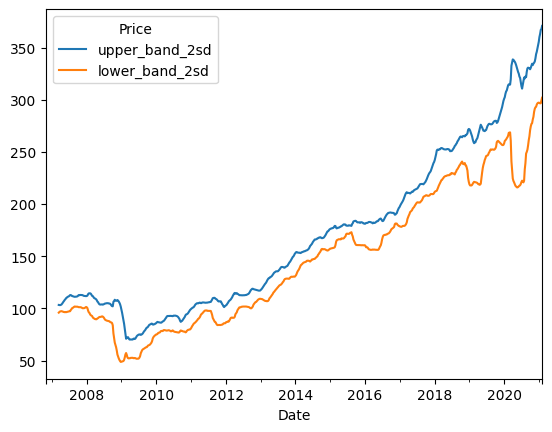

In [ ]:
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2).iloc[:,-2:]
                             .plot()
)

In [ ]:
spy_train_data_bollinger = \
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2)
)

In [ ]:
def generate_signals(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    
    signal = 0

    lst_signal = []

    for index, item in enumerate(df['Close']):
        if index ==0:
            lst_signal.append(0)
            continue
        prev_close = df['Close'].iloc[index-1] 
        close = df['Close'].iloc[index] 
        sma = df['sma_20'].iloc[index]
        lower_band = df['lower_band_2sd'].iloc[index]
        upper_band = df['upper_band_2sd'].iloc[index]

        if signal == 0:
            if (prev_close < lower_band) & (close > lower_band):
                signal = 1
            if (prev_close > upper_band) & (close < upper_band):
                signal = -1
        

        if signal == -1:
            if close < sma:
                signal = 0
        
        if signal == 1:
            if close > sma:
                signal = 0
        lst_signal.append(signal)

    df['signal'] = lst_signal
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [ ]:
spy_train_data_bollinger = \
(
    generate_signals(spy_train_data_bollinger)
)

In [ ]:
spy_train_data_bollinger

Price            Close     Volume      sma_20    std_dev  upper_band_2sd  \
Date                                                                       
2006-11-03   95.749207  215045100         NaN        NaN             NaN   
2006-11-10   96.941345  359047800         NaN        NaN             NaN   
2006-11-17   98.470078  365694400         NaN        NaN             NaN   
2006-11-24   98.420975  197045400         NaN        NaN             NaN   
2006-12-01   98.329796  491307200         NaN        NaN             NaN   
...                ...        ...         ...        ...             ...   
2021-01-08  356.948883  425078700  328.430351  15.817260      360.064872   
2021-01-15  351.743439  306035100  329.741080  16.629476      363.000032   
2021-01-22  358.465515  213770000  331.759795  17.565097      366.889988   
2021-01-29  346.472351  457381600  333.573946  17.087193      367.748332   
2021-02-05  362.987549  288507800  336.310724  17.201026      370.712775   

Price       lower_band_2sd  signal  position  
Date                                          
2006-11-03             NaN       0       0.0  
2006-11-10             NaN       0       0.0  
2006-11-17             NaN       0       0.0  
2006-11-24             NaN       0       0.0  
2006-12-01             NaN       0       0.0  
...                    ...     ...       ...  
2021-01-08      296.795830       0       0.0  
2021-01-15      296.482127       0       0.0  
2021-01-22      296.629601       0       0.0  
2021-01-29      299.399559       0       0.0  
2021-02-05      301.908672       0       0.0  

[745 rows x 8 columns]

In [ ]:
def compute_strategy_return(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()


    df['daily_return'] = \
    (
        (
            df['Close']/
            df['Close'].shift(1)
        )
        .apply(np.log)
    )

    df['cum_return'] = \
    (
        df['daily_return']
        .cumsum()
        .apply(np.exp)
    )

    df['strategy_return'] = \
    (
        (
            df['position'] 
            *
            df['daily_return']
        )
        .cumsum()
        .apply(np.exp)
    )

    return df

In [ ]:
spy_train_data_bollinger = \
(
    compute_strategy_return(spy_train_data_bollinger)
)

<Axes: xlabel='Date'>

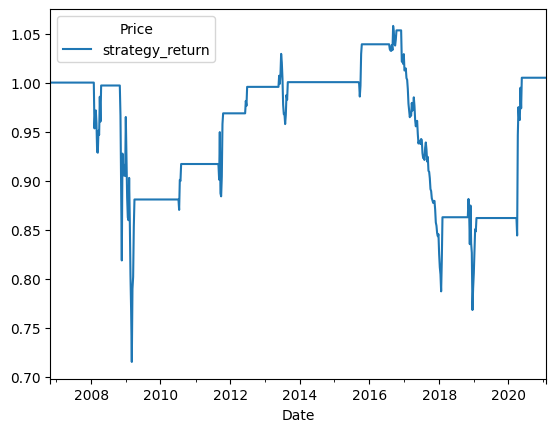

In [ ]:
spy_train_data_bollinger[['strategy_return']].plot()

<Axes: xlabel='Date'>

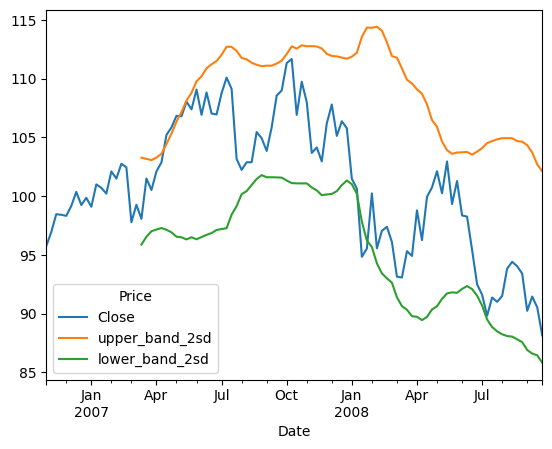

In [ ]:
spy_train_data_bollinger[['Close','upper_band_2sd','lower_band_2sd']][:100].plot()

In [ ]:
def compute_drawdown(old_df:pd.DataFrame) -> pd.DataFrame:
    df = old_df.copy()

    df['cum_max'] =\
    (
        df['strategy_return']
        .cummax()
    )

    df['drawdown'] = \
    (
        df['cum_max'] -
        df['strategy_return']
    )
    df['in_drawdown'] =\
    (
        df['cum_max'] !=
        df['strategy_return']
    )
    
    return df

In [ ]:
spy_train_data_bollinger = \
    (
        compute_drawdown(spy_train_data_bollinger)
    )

In [ ]:
spy_train_data_bollinger.iloc[-1]

Price
Close              362.987549
Volume              288507800
sma_20             336.310724
std_dev             17.201026
upper_band_2sd     370.712775
lower_band_2sd     301.908672
signal                      0
position                  0.0
daily_return         0.046566
cum_return           3.791024
strategy_return      1.004948
cum_max              1.057736
drawdown             0.052788
in_drawdown              True
Name: 2021-02-05 00:00:00, dtype: object

In [ ]:
#Run back Testing on Test data
spy_test_data_bollinger = \
(
    setup_bollinger_strategy(spy_test_data,
                            20,
                            2)
)

In [ ]:
spy_test_data_bollinger =\
(
    spy_test_data_bollinger
    .pipe(generate_signals)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
spy_test_data_bollinger

Price            Close      Volume      sma_20    std_dev  upper_band_2sd  \
Date                                                                        
2018-01-19  248.212585   461462000         NaN        NaN             NaN   
2018-01-26  253.674149   515553600         NaN        NaN             NaN   
2018-02-02  243.822144   593556800         NaN        NaN             NaN   
2018-02-09  231.473862  1347099500         NaN        NaN             NaN   
2018-02-16  241.750732   617315700         NaN        NaN             NaN   
...                ...         ...         ...        ...             ...   
2025-10-17  664.390015   457106900  634.945508  23.794619      682.534745   
2025-10-24  677.250000   337267400  639.021887  23.704735      686.431358   
2025-10-31  682.059998   374234900  643.445157  23.025969      689.497095   
2025-11-07  670.969971   395772100  647.361807  20.446399      688.254605   
2025-11-14  683.000000   134796300  650.851312  20.265663      691.382637   

Price       lower_band_2sd  signal  position  daily_return  cum_return  \
Date                                                                     
2018-01-19             NaN       0       0.0           NaN         NaN   
2018-01-26             NaN       0       0.0      0.021765    1.022004   
2018-02-02             NaN       0       0.0     -0.039612    0.982312   
2018-02-09             NaN       0       0.0     -0.051972    0.932563   
2018-02-16             NaN       0       0.0      0.043440    0.973966   
...                    ...     ...       ...           ...         ...   
2025-10-17      587.356271       0       0.0      0.017262    2.676698   
2025-10-24      591.612417       0       0.0      0.019171    2.728508   
2025-10-31      597.393219       0       0.0      0.007077    2.747886   
2025-11-07      606.469009       0       0.0     -0.016393    2.703207   
2025-11-14      610.319987       0       0.0      0.017770    2.751674   

Price       strategy_return  cum_max  drawdown  in_drawdown  
Date                                                         
2018-01-19              NaN      NaN       NaN         True  
2018-01-26           1.0000   1.0000       0.0        False  
2018-02-02           1.0000   1.0000       0.0        False  
2018-02-09           1.0000   1.0000       0.0        False  
2018-02-16           1.0000   1.0000       0.0        False  
...                     ...      ...       ...          ...  
2025-10-17           1.3371   1.3371       0.0        False  
2025-10-24           1.3371   1.3371       0.0        False  
2025-10-31           1.3371   1.3371       0.0        False  
2025-11-07           1.3371   1.3371       0.0        False  
2025-11-14           1.3371   1.3371       0.0        False  

[409 rows x 14 columns]

### Result: Bollinger

<Axes: xlabel='Date'>

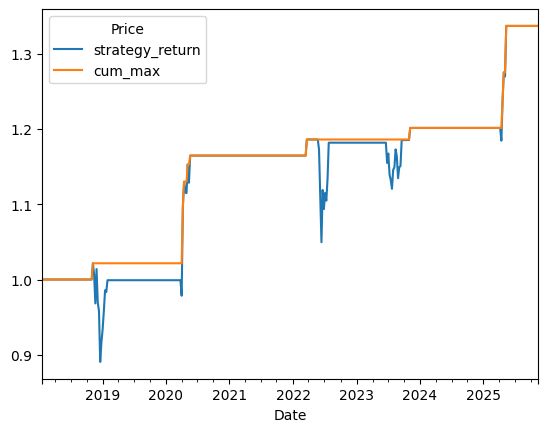

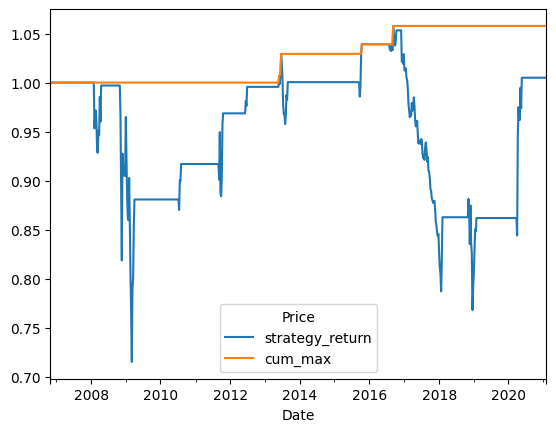

In [ ]:
spy_test_data_bollinger[['strategy_return','cum_max']].plot()
spy_train_data_bollinger[['strategy_return','cum_max']].plot()

In [ ]:
(spy_test_data_bollinger.iloc[-1,-4] 
-1
*100)

np.float64(-98.66290006716483)

In [ ]:
print(
    'Test Return (%): ',(spy_test_data_bollinger.iloc[-1,-4]-1) *100,'\n'
    'Train Return (%): ',(spy_train_data_bollinger.iloc[-1,-4] -1) *100)

Test Return (%):  33.709993283517846 
Train Return (%):  0.49482608913047343


In [ ]:
#Parameter Tuning: Bollinger Squeeze; Band Expansion; Breakout

#### Momentum Trading Strategy - RSI with MACD

In [ ]:
def RSI(old_df, period=14):
    df = old_df.copy()
    delta = df['Close'].diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    df['rsi'] = 100 - 100 / (1 + rs)
    return df

In [ ]:
def macd(old_df,
        macd_long: int = 26,
        macd_short: int = 12
        ) -> pd.DataFrame:
    
    #MACD - for trend direction
    
    df = old_df.copy()
    
    df['macd_long'] = \
    (    
        df['Close']
        .ewm(span = macd_long,
                adjust = False)
        .mean()
    )

    df['macd_short'] = \
    (
        df['Close']
        .ewm(span = macd_short,
             adjust = False)
        .mean()
    )

    df['macd'] = \
    (
        df['macd_short'] -
        df['macd_long']
    )

    df['signal_line'] = \
    (
        df['macd']
        .ewm(span = 9,
             adjust = False)
        .mean()
    )
    return df


In [ ]:
def generate_signals_rsi_macd(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    df['signal'] = \
    (
        np
        .select(
            [
                (df['rsi'] > 30) & (df['macd'] > df['signal_line']),
                (df['rsi'] < 70) & (df['macd'] < df['signal_line'])
            ],
            [
                1,
                -1
            ],
            0
        )
    )
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [ ]:
spy_train_data_rsi_macd =\
(
    spy_train_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
spy_test_data_rsi_macd = \
(
    spy_test_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

<Axes: xlabel='Date'>

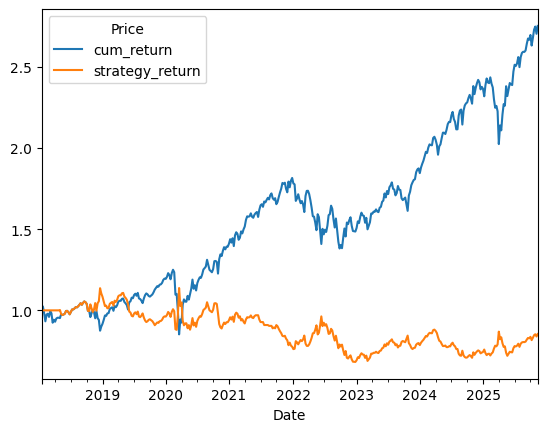

In [ ]:
spy_test_data_rsi_macd[['cum_return','strategy_return']].plot()

In [ ]:
def setup_buy_new_high(
        old_df,
        num_long_entry:int,
        num_short_entry: int,
        num_long_exit:int,
        num_short_exit: int) -> pd.DataFrame:
    
    df = old_df.copy()

    df['delta'] =\
    (
        df['Close']
        .diff()
    )

    df['up_trend'] =\
    (
        (
            df['delta'] > 0
        )
        .astype(int)
    )

    df['down_trend'] =\
    (
        (
            df['delta'] < 0
        )
        .astype(int)
    )
    
    #entry
    df['entry_short'] = \
    (
        df['up_trend']
        .rolling(num_short_entry)
        .sum() 
        == 
        num_short_entry
    )

    df['entry_long'] = \
    (
        df['down_trend']
        .rolling(num_long_entry)
        .sum() 
        == 
        num_long_entry
    )

    df['exit_short']  = \
    (
        df['down_trend']
        .rolling(num_short_exit)
        .sum() 
        == 
        num_short_exit
    )

    df['exit_long']  = \
    (
        df['up_trend']
        .rolling(num_long_exit)
        .sum() 
        == 
        num_long_exit
    )

    signals = []
    signal = 0

    for short_entry, long_entry, short_exit, long_exit in zip(
        df['entry_short'], 
        df['entry_long'],
        df['exit_short'], 
        df['exit_long']
    ):

        if signal == 0:
            if short_entry:
                signal = -1
            if long_entry:
                signal = 1

        elif signal == 1 and long_exit:
            signal = 0

        elif signal == -1 and short_exit:
            signal = 0

        signals.append(signal)

    df['signal'] = signals

    #stack buy
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
    )
    return df

<Axes: xlabel='Date'>

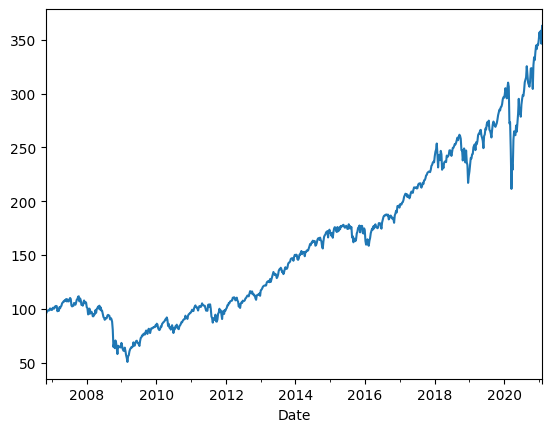

In [ ]:
spy_train_data['Close'].plot()

In [ ]:
df_ret = pd.DataFrame()

for entry_l in range(2,10):
    for entry_s in range(2,10):
        for exit_l in range(2,10):
            for exit_s in range(2,10):
                a = spy_train_data.copy()
                a = \
                (
                    setup_buy_new_high(a,entry_l,entry_s,exit_l,exit_s)
                    .pipe(compute_strategy_return)
                    .pipe(compute_drawdown)
                )
                df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
df_ret['buy_and_hold'] = a['cum_return'].copy()

C:\Users\USER\AppData\Local\Temp\ipykernel_11012\3793772336.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
C:\Users\USER\AppData\Local\Temp\ipykernel_11012\3793772336.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
C:\Users\USER\AppData\Local\Temp\ipykernel_11012\3793772336.py:14: PerformanceWarning: DataFrame is highly fra

In [ ]:
(df_ret.iloc[-1].sort_values(ascending=False)).head(30)

stra_ret_entry2_2_exit4_2    6.977937
stra_ret_entry4_5_exit9_6    6.687333
stra_ret_entry4_4_exit9_6    6.625742
stra_ret_entry2_2_exit5_2    6.424935
stra_ret_entry2_2_exit6_2    6.236911
stra_ret_entry6_2_exit9_2    5.105304
stra_ret_entry5_2_exit9_2    5.005470
stra_ret_entry6_3_exit9_4    4.949731
stra_ret_entry5_3_exit9_4    4.852939
stra_ret_entry4_3_exit9_4    4.852939
stra_ret_entry6_3_exit9_3    4.819215
stra_ret_entry3_5_exit9_6    4.784235
stra_ret_entry6_2_exit9_3    4.772424
stra_ret_entry3_4_exit9_6    4.740172
stra_ret_entry5_3_exit9_3    4.724975
stra_ret_entry3_5_exit9_5    4.712648
stra_ret_entry5_5_exit9_5    4.712648
stra_ret_entry6_5_exit9_5    4.712648
stra_ret_entry4_5_exit9_5    4.712648
stra_ret_entry6_5_exit9_3    4.685545
stra_ret_entry4_3_exit9_6    4.680454
stra_ret_entry5_2_exit9_3    4.679100
stra_ret_entry6_4_exit9_5    4.669244
stra_ret_entry3_4_exit9_5    4.669244
stra_ret_entry4_4_exit9_5    4.669244
stra_ret_entry5_4_exit9_5    4.669244
stra_ret_ent

In [ ]:
a =\
(
    setup_buy_new_high(

        spy_test_data,
        2,
        2,
        4,
        2
    )
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

### Strategy B

<Axes: xlabel='Date'>

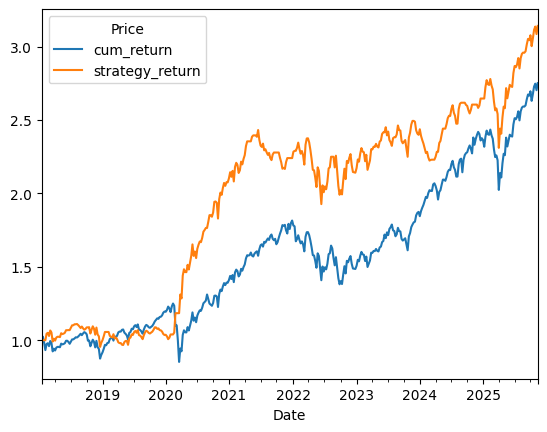

In [ ]:
a[['cum_return','strategy_return']].plot()

## (1C) Machine Learning

### Strategy C

In [216]:
stock_ticker = ["META", "AMZN", "AAPL", "NFLX", "GOOG", "SPY"]
forex_ticker = ["DEXUSEU", "DEXJPUS", "DEXUSUK", "DEXSZUS", "DEXCAUS", "DEXUSAL", "DEXUSNZ", "DEXNOUS", "DEXSDUS"]
index_ticker = ["DX-Y.NYB","GC=F", "CL=F", "HG=F", "^VIX"]
yield_ticker = ["^IRX", "^FVX", "^TNX"]

In [87]:
### download data
stock_data =\
(
    download_data(stock_ticker,
                  close_only = True)
)

forex_data =\
(
    pdr
    .get_data_fred(forex_ticker,
                  stock_data.index[0],
                  stock_data.index[-1])
)

index_data =\
(
    download_data(index_ticker,
                  close_only = True)
)

yield_data =\
(
    download_data(yield_ticker,
                  close_only = True)
)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  3 of 3 completed


In [89]:
index_data = index_data.where(index_data > 0)
index_data = index_data.ffill()

In [271]:
# technical indicators
technical_data1 = {}
technical_data2 = {}
target_data =\
(
    stock_data.loc[: , "SPY"]
    .copy()
)

In [272]:
sma_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
ema_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
rsi_periods = [2, 5, 7, 10, 14, 21, 28]
ROC_periods = [5, 10, 21, 50, 63, 126, 200, 252]        
MOM_periods = [5, 10, 21, 50, 63, 126, 200, 252]         
stochastic_periods = [5, 10, 14, 21]
return_period = 5    

In [273]:
# sma
for i in sma_periods:
    technical_data1[f"{i}_SMA"] =\
    (
        target_data
        .rolling(window = i)
        .mean()
    )

    # ema
for i in ema_periods:
    technical_data1[f"{i}_EMA"] =\
    (
        target_data
        .ewm(span = i)
        .mean()
    )

# rsi
def RSI(data, period):
    price_diff =\
    (
        data
        .diff()
        .dropna()
    )

    up = price_diff * 0
    down = up.copy()

    up[price_diff > 0] = price_diff[price_diff > 0]
    down[price_diff < 0] = -price_diff[price_diff < 0]

    up[up.index[period - 1]] = np.mean( up[ :period])
    up = up.drop(up.index[ :(period - 1)]
                )
    down[down.index[period - 1]] = np.mean( down[ :period])
    down = down.drop(down.index[ :(period - 1)]
                    )

    rs =\
    (
        up.ewm(com = period - 1,
               adjust = False).mean()
        /
        down.ewm(com = period - 1,
                 adjust = False).mean()
    )

    return 100 - 100 / (1 + rs)
    
for i in rsi_periods:
    technical_data2[f"{i}_RSI"] = RSI(target_data, i)

# RoC
def ROC(data, period):
    M = data.diff(period - 1)
    N = data.shift(period - 1)
    ROC = (M / N) * 100

    return ROC
for i in ROC_periods:
    technical_data2[f"{i}_ROC"] = ROC(target_data, i)   

# Price momentum
def MOM(data, periods):
    MOM = data.diff(periods)
    return MOM
for i in MOM_periods:
    technical_data2[f"{i}_MOM"] = MOM(target_data, i)

# Stochastic Oscillator data
stochastic_oscillator_data =\
(
    yf
    .download("SPY",
              start_date,
              end_date)
    [["Close", "Low", "High"]]
)

stochastic_oscillator_data.columns =\
(
    stochastic_oscillator_data
    .columns
    .droplevel(1)
)

# Stochastic Oscillator
def STOK(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    return STOK

def STOD(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    STOD = STOK.rolling(3).mean()
    return STOD

for i in stochastic_periods:
        technical_data2[f"{i}_%K"] = STOK(period = i)
        technical_data2[f"{i}_%D"] = STOD(period = i) 

[*********************100%***********************]  1 of 1 completed


In [274]:
# convert to df    
technical_data1 =\
(
    pd
    .DataFrame(technical_data1)
)

technical_data2 =\
(
    pd
    .DataFrame(technical_data2)
)

In [275]:
# setting of variables
Y =\
(
    np
    .log(stock_data.loc[ : , "SPY"]
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name =\
(
    Y
    .name
    +
    "_pred"
)

In [276]:
X1 =\
(
    np
    .log(stock_data.loc[ : , ("META", "AMZN", "AAPL", "NFLX", "GOOG")]
        )
    .diff(return_period)   
)

X2 =\
(
    np
    .log(forex_data)
    .diff(return_period)
)

X3 =\
(
    np
    .log(index_data)
    .diff(return_period)
)

X4 =\
(
    yield_data
    .diff(return_period)
    * 100
)

X5 =\
pd.concat(
    [np
     .log(stock_data.loc[ : , "SPY"]
         )
     .diff(i) for i in [return_period,
                        return_period * 3, # 15
                        return_period * 6, # 30
                        return_period * 12 # 60
                       ]
    ],
    axis = 1
).dropna()
X5.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]


X6 =\
(
    np
    .log(technical_data1)
    .diff(return_period)
)

X7 =\
(
    technical_data2
    .diff(return_period)
)



In [277]:
X =\
(
    pd
    .concat([X1, X2, X3, X4, X5, X6],
           axis =1)
)

X

META      AMZN      AAPL      NFLX      GOOG   DEXUSEU  \
2006-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-02       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-03       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-06       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-07       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-11-06 -0.073987  0.086682 -0.006024  0.007338  0.012129 -0.002164   
2025-11-07 -0.041957  0.000778 -0.007052 -0.013678 -0.007551  0.003201   
2025-11-10 -0.009374 -0.022294  0.002380  0.017999  0.022517  0.001213   
2025-11-11 -0.000383 -0.000883  0.020079  0.039011  0.048026       NaN   
2025-11-12 -0.043285 -0.024273  0.013220  0.052353  0.009368  0.009273   

             DEXJPUS   DEXUSUK   DEXSZUS   DEXCAUS  ...   500_SMA     5_EMA  \
2006-11-01       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2006-11-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2006-11-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2006-11-06       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2006-11-07       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2025-11-06 -0.007814 -0.003047  0.006091  0.010317  ...  0.004551 -0.007866   
2025-11-07 -0.006447  0.001825  0.001618  0.004629  ...  0.004496 -0.010702   
2025-11-10 -0.000909  0.000532 -0.001363 -0.001425  ...  0.004464 -0.008052   
2025-11-11       NaN       NaN       NaN       NaN  ...  0.004473 -0.001561   
2025-11-12  0.003433  0.006111 -0.016792 -0.007685  ...  0.004448  0.001804   

              10_EMA    21_EMA    50_EMA    63_EMA   100_EMA   200_EMA  \
2006-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-02       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-03       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-06       NaN       NaN       NaN       NaN       NaN       NaN   
2006-11-07       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2025-11-06 -0.001084  0.002845  0.004648  0.004949  0.005241  0.004855   
2025-11-07 -0.003865  0.001088  0.003806  0.004263  0.004791  0.004624   
2025-11-10 -0.003667  0.000732  0.003540  0.004035  0.004633  0.004543   
2025-11-11 -0.000919  0.001711  0.003856  0.004273  0.004774  0.004618   
2025-11-12  0.000802  0.002335  0.004044  0.004410  0.004852  0.004660   

             252_EMA   500_EMA  
2006-11-01       NaN       NaN  
2006-11-02       NaN       NaN  
2006-11-03       NaN       NaN  
2006-11-06       NaN       NaN  
2006-11-07       NaN       NaN  
...              ...       ...  
2025-11-06  0.004650  0.004112  
2025-11-07  0.004465  0.004014  
2025-11-10  0.004400  0.003981  
2025-11-11  0.004462  0.004017  
2025-11-12  0.004498  0.004038  

[4966 rows x 44 columns]

In [278]:
data =\
(
    pd
    .concat([Y, X],
           axis = 1)
    .dropna()
)

data =\
(
    data
    .iloc[ : :return_period, : ]
)

In [279]:
Y =\
(
    data
    .loc[ : ,Y.name]
)

X =\
(
    data
    .loc[ : , X.columns]
)

In [280]:
testing_set = 0.25

train_size = int(len(X) * (1 - testing_set))

Y_train, Y_test =\
(
    Y[0 : train_size],
    Y[train_size:len(Y)]
)

X_train, X_test =\
(
    X[0: train_size],
    X[train_size:len(X)]
)

In [281]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [282]:
X_train_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_train),
            index = X_train.index,
            columns = X_train.columns
        )
    )

X_test_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_test),
            index = X_test.index,
            columns = X_test.columns
        )
    )

In [283]:
models =\
[
    ("LR", LinearRegression()),
    ("Elastic Net Penalty", ElasticNet()),
    ("LASSO", Lasso()),
    ("Support Vector Machine", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Extra Trees Algo", ExtraTreesRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("Adaptive Boosting", AdaBoostRegressor())
]

In [290]:
names = []

train_results = []
test_results = []

kfold_results = []

best_models = {}
ml_equity_curves = {}
results = []
ncomps_list = [5, 10 ,15, 20, 25, 30, 35, 40]

In [291]:
seed = 627
num_folds = 10
ncomps = 30
metric = "neg_mean_squared_error"

Variance preserved by first 30 components == 99.18%


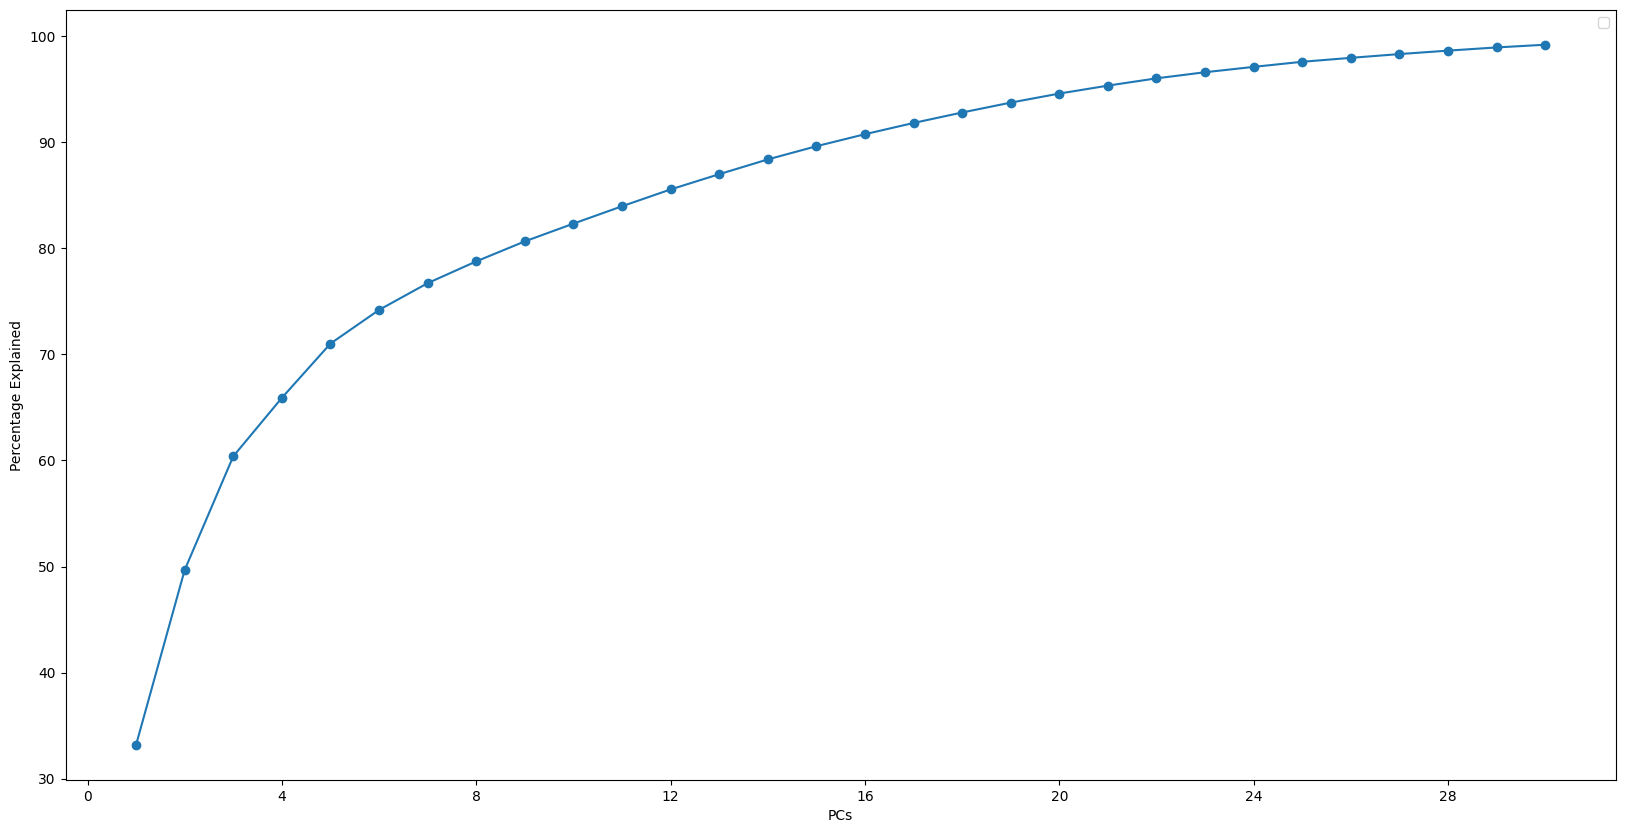

In [292]:
svd_for_plot = TruncatedSVD(n_components=ncomps, random_state=seed)
svd_for_plot.fit(X_train_scaled)

plt_data = pd.DataFrame(
    svd_for_plot.explained_variance_ratio_.cumsum() * 100,
    index=np.arange(1, ncomps + 1),
    columns=["cum_var_explained"]
)

ax = plt_data.plot(kind="line", figsize=(20, 10), style="o-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("PCs")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print(
    "Variance preserved by first {} components == {:.2%}".format(
        ncomps,
        svd_for_plot.explained_variance_ratio_.cumsum()[-1]
    )
)

In [293]:
param_grids =\
{
    "LR":\
    {
        "model__fit_intercept": [True, False]
    },

    "Elastic Net Penalty":\
    {
        "model__alpha": np.logspace(-4, 2, 7),
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [5000]
    },

    "LASSO":\
    {
        "model__alpha": np.logspace(-5, 1, 7),
        "model__max_iter": [5000]
    },

    "Support Vector Machine":\
    {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"],
        "model__epsilon": [0.001, 0.01, 0.1],
        "model__kernel": ["rbf"]
    },

    "K-Nearest Neighbors":\
    {
        "model__n_neighbors": [3, 5, 9, 15],
        "model__weights": ["uniform", "distance"]
    },

    "Decision Tree":\
    {
        "model__max_depth": [3, 5, 10, None],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },

    "Extra Trees Algo":\
    {
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", None]
    },

    "Random Forest":\
    {
        "model__n_estimators": [150, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 10],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": ["sqrt", None]
    },

    "Gradient Boosting":\
    {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.6, 0.8],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1, 2]
    },

    "Adaptive Boosting":\
    {
        "model__n_estimators": [50, 150],
        "model__learning_rate": [0.05, 0.5],
        "model__loss": ["linear", "square"]
    }
}


In [294]:
def calculate_ml_results(y_true,
                        y_pred,
                        return_period = return_period,
                        initial_capital = 1e5
                        ):
    data =\
    (
        pd
        .concat(
            [y_true.rename("y_true"),
             y_pred.rename("y_pred")],
             axis = 1
        )
        .dropna()
    )

    signal =\
    (
        np
        .sign(data["y_pred"])   
    )

    position =\
    (
        signal
        .shift(1)
        .fillna(0)
    )

    strategy_returns =\
    (
        position
        *
        data["y_true"]
    )

    equity_curve =\
    (
        np
        .exp(strategy_returns.cumsum())
        *
        initial_capital
    )

    periods_per_year =\
    (
        252
        /
        return_period
    )

    mean_return =\
    (
        strategy_returns
        .mean()
    )

    std_return =\
    (
        strategy_returns
        .std()
    )

    sharpe =\
    (
        mean_return
        /
        std_return
        *
        np.sqrt(periods_per_year)
    )

    n_periods = strategy_returns.shape[0]
    years = n_periods / periods_per_year

    final_equity = equity_curve.iloc[-1]

    cagr =\
    (
        (final_equity / initial_capital) ** (1/ years)
        - 1
    )

    running_max =\
    (
        equity_curve
        .cummax()
    )

    drawdown =\
    (
        equity_curve
        /
        running_max
        - 1
    )

    max_drawdown = drawdown.min()
    
    results =\
    {
        "sharpe": sharpe,
        "cagr": cagr,
        "max_drawdown": max_drawdown,
        "final_equity": final_equity,
        "equity_curve": equity_curve
    }

    return results

In [295]:
for ncomps in ncomps_list:
    print(f"\n===== Running models for ncomps = {ncomps} =====")

    for name, model in models:

        names.append(f"{name}_nc{ncomps}")

        kfold =\
        (
            KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True)
        )

        # run SVD
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svd", TruncatedSVD(n_components = ncomps, random_state = seed)),
            ("model", model)
        ])

        param_grid = param_grids.get(name, {})

        grid_search =\
        (
            GridSearchCV(estimator = pipe,
                        param_grid = param_grid,
                        cv = kfold,
                        scoring = metric,
                        n_jobs = -1)
        )

        grid_search.fit(X_train, Y_train)

        res = grid_search.best_estimator_
        best_models[(name, ncomps)] = res
        best_index = grid_search.best_index_

        cv_scores =\
        (
            np
            .array(
                [grid_search.cv_results_[f"split{i}_test_score"][best_index]
                for i in range(num_folds)]
            )
        )
        
        cv_scores = -1 * cv_scores

        kfold_results.append(cv_scores)

        train_result = mean_squared_error(res.predict(X_train), Y_train)
        train_results.append(train_result)

        # Assess the performance in Testing Set

        test_result = mean_squared_error(res.predict(X_test), Y_test)
        test_results.append(test_result)

        y_pred_test =\
        (
            pd
            .Series(res.predict(X_test),
                    index = Y_test.index,
                    name = f"{name}_nc{ncomps}_pred"
                    )
        )

        bt_results =\
        (
            calculate_ml_results(y_true = Y_test,
                                y_pred = y_pred_test)
        )
        
        ml_equity_curves[(name, ncomps)] = bt_results["equity_curve"]

        results.append(
            {
                "Model": name,
                "ncomps": ncomps,
                "CV_MSE_mean": cv_scores.mean(),
                "CV_MSE_std":  cv_scores.std(),
                "Train_MSE":   train_result,
                "Test_MSE":    test_result,
                "Sharpe":      bt_results["sharpe"],
                "CAGR":        bt_results["cagr"],
                "Max_Drawdown":bt_results["max_drawdown"],
                "Final_Equity":bt_results["final_equity"],
                "Best_Params": grid_search.best_params_
            }
        )
        user_interface_message = "%s: %f (%f) %f %f Sharpe=%f CAGR=%f MDD=%f Final=%f" %\
        (
            name, 
            cv_scores.mean(), 
            cv_scores.std(), 
            train_result, 
            test_result,
            bt_results["sharpe"],
            bt_results["cagr"],
            bt_results["max_drawdown"],
            bt_results["final_equity"]
        )
        print(user_interface_message)


===== Running models for ncomps = 5 =====


LR: 0.000438 (0.000136) 0.000412 0.000505 Sharpe=1.101405 CAGR=0.193915 MDD=-0.182456 Final=176151.698729
Elastic Net Penalty: 0.000419 (0.000119) 0.000417 0.000514 Sharpe=1.093836 CAGR=0.192495 MDD=-0.182456 Final=175483.645737
LASSO: 0.000419 (0.000119) 0.000417 0.000514 Sharpe=1.093836 CAGR=0.192495 MDD=-0.182456 Final=175483.645737
Support Vector Machine: 0.000449 (0.000111) 0.000255 0.000593 Sharpe=1.125332 CAGR=0.198408 MDD=-0.182456 Final=178278.198114
K-Nearest Neighbors: 0.000440 (0.000124) 0.000000 0.000549 Sharpe=1.445045 CAGR=0.259327 MDD=-0.136715 Final=208875.334418
Decision Tree: 0.000442 (0.000095) 0.000362 0.000611 Sharpe=1.226709 CAGR=0.217552 MDD=-0.190721 Final=187536.292203
Extra Trees Algo: 0.000418 (0.000120) 0.000352 0.000524 Sharpe=0.949543 CAGR=0.165635 MDD=-0.182456 Final=163166.234711
Random Forest: 0.000432 (0.000108) 0.000210 0.000582 Sharpe=0.562701 CAGR=0.095654 MDD=-0.190721 Final=133885.751389
Gradient Boosting: 0.000446 (0.000104) 0.000299 0.000639 Sh

In [302]:
results_df =\
(
    pd
    .DataFrame(results)
    .set_index(["Model", "ncomps"])
).sort_values(by = "Final_Equity",
              ascending = False)

results_df


CV_MSE_mean  CV_MSE_std     Train_MSE  Test_MSE  \
Model               ncomps                                                    
Gradient Boosting   10         0.000428    0.000105  2.731343e-04  0.000582   
K-Nearest Neighbors 5          0.000440    0.000124  0.000000e+00  0.000549   
                    25         0.000437    0.000125  2.590047e-17  0.000551   
Decision Tree       5          0.000442    0.000095  3.620208e-04  0.000611   
Adaptive Boosting   5          0.000428    0.000123  3.591053e-04  0.000560   
...                                 ...         ...           ...       ...   
Gradient Boosting   30         0.000447    0.000154  1.554826e-04  0.000616   
                    35         0.000448    0.000152  2.363570e-04  0.000633   
LR                  35         0.000475    0.000158  3.696917e-04  0.000590   
Extra Trees Algo    30         0.000415    0.000116  2.082249e-04  0.000508   
Gradient Boosting   40         0.000444    0.000151  2.340937e-04  0.000573   

                              Sharpe      CAGR  Max_Drawdown   Final_Equity  \
Model               ncomps                                                    
Gradient Boosting   10      1.580206  0.285519     -0.130209  223071.911049   
K-Nearest Neighbors 5       1.445045  0.259327     -0.136715  208875.334418   
                    25      1.331592  0.237532     -0.182456  197545.093109   
Decision Tree       5       1.226709  0.217552     -0.190721  187536.292203   
Adaptive Boosting   5       1.226709  0.217552     -0.190721  187536.292203   
...                              ...       ...           ...            ...   
Gradient Boosting   30     -0.041444 -0.006727     -0.198934   97867.048365   
                    35     -0.085602 -0.013843     -0.275690   95644.696204   
LR                  35     -0.189472 -0.030375     -0.330391   90616.423844   
Extra Trees Algo    30     -0.191675 -0.030722     -0.295248   90512.750516   
Gradient Boosting   40     -0.387958 -0.061138     -0.254588   81748.120960   

                                                                  Best_Params  
Model               ncomps                                                     
Gradient Boosting   10      {'model__learning_rate': 0.05, 'model__max_dep...  
K-Nearest Neighbors 5       {'model__n_neighbors': 15, 'model__weights': '...  
                    25      {'model__n_neighbors': 15, 'model__weights': '...  
Decision Tree       5       {'model__max_depth': 3, 'model__min_samples_le...  
Adaptive Boosting   5       {'model__learning_rate': 0.05, 'model__loss': ...  
...                                                                       ...  
Gradient Boosting   30      {'model__learning_rate': 0.05, 'model__max_dep...  
                    35      {'model__learning_rate': 0.05, 'model__max_dep...  
LR                  35                         {'model__fit_intercept': True}  
Extra Trees Algo    30      {'model__max_depth': 10, 'model__max_features'...  
Gradient Boosting   40      {'model__learning_rate': 0.05, 'model__max_dep...  

[80 rows x 9 columns]

In [297]:
from lets_plot import *
LetsPlot.setup_html()

In [298]:
df_for_plot =\
(
    pd
    .DataFrame(
        {"Algorithms": names * 2,
         "Data": ["Training Set"] * len(names) + ["Testing Set"] * len(names),
         "Performance": train_results + test_results
        }
    )
)


In [ ]:
for (name, ncomps),  fitted_pipe in best_models.items():
    print(f"\n=== Fitting and plotting for model: {name} ===")

    # predict on test set
    y_predictions = fitted_pipe.predict(X_test)

    # Convert predictions to Series aligned with Y_test index
    y_predictions = pd.Series(
        data=y_predictions,
        index=Y_test.index,
        name=f"{name} Predictions"
    )

    # Build cumulative return curves
    actual_results = np.exp(Y_test).cumprod()
    pred_results   = np.exp(y_predictions).cumprod()

    difference = actual_results - pred_results

    # Build DataFrame for plotting
    df_outcome = pd.DataFrame(
        {
            "date": actual_results.index,
            "future SPY": actual_results.values,
            "predicted SPY": pred_results.values,
            "difference": difference.values
        }
    )

    # Long format for lets-plot
    df_outcome_ggplot = df_outcome.melt(
        id_vars=["date", "difference"],
        var_name="series",
        value_name="value"
    )

    # Dynamic y-limit so plots scale nicely
    y_max = float(df_outcome_ggplot["value"].max() * 1.1)

    # Plot using lets-plot
    p = \
    (
        ggplot(df_outcome_ggplot, aes(x="date", y="value", color="series"))
        + geom_line()
        + geom_point()
        + scale_y_continuous(limits=[0, y_max])
        + scale_color_manual(
            values={
                "future SPY": "blue",
                "predicted SPY": "red"
            }
        )
        + ggtitle(f"Predicting SPY Cumulative Returns with {name}")
        + xlab("Date")
        + ylab("Cumulative Returns")
        + theme(legend_position="top")
        + ggsize(1000, 500)
    )

    # show plot for this model
    p.show()



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===



=== Fitting and plotting for model: LR ===



=== Fitting and plotting for model: Elastic Net Penalty ===



=== Fitting and plotting for model: LASSO ===



=== Fitting and plotting for model: Support Vector Machine ===



=== Fitting and plotting for model: K-Nearest Neighbors ===



=== Fitting and plotting for model: Decision Tree ===



=== Fitting and plotting for model: Extra Trees Algo ===



=== Fitting and plotting for model: Random Forest ===



=== Fitting and plotting for model: Gradient Boosting ===



=== Fitting and plotting for model: Adaptive Boosting ===


In [303]:
bh_pred = pd.Series(
    data = 1.0,
    index = Y_test.index,
    name = "buy_and_hold_pred"
)

bh_results = calculate_ml_results(
    y_true = Y_test,
    y_pred = bh_pred,        
    return_period = return_period,
    initial_capital = 1e5    
)

bh_sharpe = bh_results["sharpe"]
bh_cagr = bh_results["cagr"]
bh_mdd = bh_results["max_drawdown"]
bh_final_equity = bh_results["final_equity"]
bh_equity_curve = bh_results["equity_curve"]

print("Buy & Hold SPY (test period)")
print(f"Sharpe:{bh_sharpe:.3f}")
print(f"CAGR:{bh_cagr:.3%}")
print(f"Max Drawdown:{bh_mdd:.2%}")
print(f"Final Balance:{bh_final_equity:,.2f}")

Buy & Hold SPY (test period)
Sharpe:1.094
CAGR:19.250%
Max Drawdown:-18.25%
Final Balance:175,483.65


In [311]:
strategy_name = "Gradient Boosting"
strategy_ncomps = 10

strategy_equity = ml_equity_curves[(strategy_name, strategy_ncomps)]
bh_equity = bh_equity_curve   

df_plot = pd.DataFrame({
    "date": strategy_equity.index,
    "Strategy": strategy_equity.values,
    "Buy_and_Hold": bh_equity.reindex(strategy_equity.index).values
})

df_long = df_plot.melt(
    id_vars="date",
    var_name="series",
    value_name="equity"
)

p =\
(
    ggplot(df_long, aes(x="date", y="equity", color="series"))
    + geom_line()
    + ggtitle(f"Equity Curve: {strategy_name} (ncomps={strategy_ncomps}) vs Buy & Hold SPY")
    + xlab("Date")
    + ylab("Portfolio Value")
    + theme(legend_position="top")
    + ggsize(1000, 500)
)

p.show()

In [326]:
# Strategy data
row = results_df.loc[(strategy_name, strategy_ncomps)]
st_sharpe = row["Sharpe"]
st_cagr = row["CAGR"]
st_mdd = row["Max_Drawdown"]
st_final_equity = row["Final_Equity"]

# Compute differences (strategy minus buy & hold)
sharpe_diff = st_sharpe - bh_sharpe
cagr_diff_pct = (st_cagr - bh_cagr) * 100 
mdd_diff_pct = (st_mdd - bh_mdd)  * 100
final_equity_diff = st_final_equity - bh_final_equity

print(f"=== Strategy vs Buy & Hold (Test Period) ===")
print(f"Sharpe (Strategy):{st_sharpe:.3f}")
print(f"Sharpe (Buy & Hold):{bh_sharpe:.3f}")
print(f"Sharpe Difference:{sharpe_diff:+.3f}")

print()
print(f"CAGR (Strategy):{st_cagr*100:6.2f}%.")
print(f"CAGR (Buy & Hold):{bh_cagr*100:6.2f}%.")
print(f"CAGR Difference:{cagr_diff_pct:+6.2f}%.")

print()
print(f"Max Drawdown (Strategy):{st_mdd*100:6.2f}%")
print(f"Max Drawdown (B&H):{bh_mdd*100:6.2f}%")
print(f"MDD Difference:{mdd_diff_pct:+6.2f}% ")

print()
print(f"Final Equity (Strategy):{st_final_equity:,.2f}")
print(f"Final Equity (B&H):{bh_final_equity:,.2f}")
print(f"Final Equity Difference:+${final_equity_diff:,.2f}")

=== Strategy vs Buy & Hold (Test Period) ===
Sharpe (Strategy):1.580
Sharpe (Buy & Hold):1.094
Sharpe Difference:+0.486

CAGR (Strategy): 28.55%.
CAGR (Buy & Hold): 19.25%.
CAGR Difference: +9.30%.

Max Drawdown (Strategy):-13.02%
Max Drawdown (B&H):-18.25%
MDD Difference: +5.22% 

Final Equity (Strategy):223,071.91
Final Equity (B&H):175,483.65
Final Equity Difference:+$47,588.27


# Part 2: Visualisations and Comparisons

**The 3 Strategies**

1. Momentum Trading Strategy: Moving Average

2. Mean-Reverting Strategy:

3. Gradient Boosting Strategy

# Part 3. Executive Summary of Trading Strategies and Backtesting Results

## The 3 Strategies

**The 3 Strategies employed** includes one from each category, with the results compared against the benchmark return from the periods of `11 February 2021` to `12 November 2025`

_Strategy A: (Momentum Trading)_ 


_Strategy B: (Mean-Reversion)_


_Strategy C: (Machine Learning) - Gradient Boosting_



<font size = 4.5>_**Metrics Generated**_</font>

**1. Sharpe Ratio** <br />
Measures risk-adjusted return by scaling the average return by its volatility. A higher Sharpe Ratio indicates that a strategy generates more return per unit of risk.

**2. Compound Annual Growth Rate (CAGR)** <br />
Summarises the long-run growth rate of the portfolio. It captures how quickly wealth compounds over the full sample period.

**3. Maximum and Longest Drawdown (MDD)** <br />
Quantifies the worst peak-to-trough loss experienced by the strategy. This is a key indicator of downside risk and how long the portfolio experiences drawdown, which is not a rational investor with a degree of risk aversion would like to see.


## Strategy A

Strategy A is built on the idea that returns tend to exhibit persistence: strong recent performance can be followed by further gains, while recent weakness can be followed by additional losses. In practice, we construct a momentum signal using past S&P 500 returns over a fixed lookback window. When the recent cumulative return is sufficiently positive, the strategy takes or increases a long position; when the recent cumulative return is sufficiently negative, the strategy either reduces risk or, depending on the rule specification, may take a short position.

The economic intuition is that momentum benefits from extended trending regimes: prolonged bull markets or deep bear markets in which price moves in one direction for some time. Conversely, the strategy is vulnerable to sideways markets with frequent reversals, where trend signals whipsaw and turnover increases.

This was done by combining multiple momentum indicators (RSI, ROC, FI, SMA, EMA) and a iteration of a combination of any mixture of them based on a grid of possible values. To prevent overfitting, maximum number of indicators allowed was set to 4. 

**Why this ROC combo can logically beat the market?**

The ROC_5 + ROC_10 + ROC_20 + ROC_40 setup is basically a multi-horizon momentum filter:

Short-term ROC (5–10 days) responds quickly to changes in trend and helps the strategy reduce exposure when price action turns against it.

Medium-term ROC (20–40 days) captures more persistent moves and prevents over-reacting to very short-term noise.

By combining several ROCs instead of relying on a single lookback, the strategy diversifies its timing signal. One horizon may whipsaw, but the others can “vote it down”, so you only take trades when there is consistent strength or weakness across multiple windows.

This combination naturally tilts the portfolio toward assets and periods with positive price momentum and scales down when momentum weakens. Because equity returns are not purely random walk and exhibit trend and autocorrelation over these horizons, the strategy can systematically harvest momentum premia that a passive SPY holder does not.



**Summary of Results**

Portfolio       |   Strategy A      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.14            |   0.770       |
CAGR            |   15.99%          |  14.1%       |
Max Drawdown    | -12.87%           |   -18.25%     |
Final Value     |   $202,539.038    | $187,040.08   |


Risk-adjusted performance:

SPY’s Sharpe over the test period is about 0.77, while my strategy’s Sharpe is 1.14. That’s roughly a 48% improvement in risk-adjusted return. In other words, for each unit of risk taken, the strategy is delivering a lot more excess return than the market.

Growth of capital:

SPY compounds at about 14.1% CAGR, whereas the strategy compounds at ~15.99% CAGR. That’s a +1.9 percentage point edge per year, or around 13% higher annual growth relative to SPY. Over the full backtest this shows up as final equity of 202.5k vs 187.0k for SPY about +8.3% more wealth for the same starting capital.

Drawdowns and risk:

SPY’s max drawdown in the sample is around -24.5%, while the strategy’s worst loss from peak is only about -12.9%. So the strategy not only grows faster, it does so with roughly half the maximum pain. Smaller drawdowns also help compounding because you spend less time digging out of deep holes.

## Strategy B

Strategy B takes a contrarian view - instead of betting on trends, it assumes that prices tend to revert towards some “fair value” or medium-term equilibrium. This is operationalised by comparing the current S&P 500 level to a lagged close value of itself.

A typical implementation uses a standardised price change relative to its rolling mean. When the index trades far below its standardised value (RSI 30 value), the strategy interprets this as an oversold condition and increases long exposure. When the index trades far above its standardised value (RSI 70 value), the strategy treats this as an overbought condition and reduces or even reverses the position.

The intuition is that mean-reversion strategies tend to perform better in choppy or range-bound markets, where deviations from the average are repeatedly corrected. 

Strategy B uses RSI combined with MACD strategy. After running the strategy with 1-50 parameters for RSI, long and short macd. stra_35_3_1 RSI 35, long macd of 3 and short macd of 1 was noted to be the highest training cumulative return of 2.201404. However the model was overfitted which lead to testing data showing 1.014893 return, much lower as compared to buy and hold strategy of 1.859016.


## Strategy C

Strategy C employs a supervised machine learning approach to predict the 5-day forward log returns of the SPY ETF. A panel of models was run using a pipeline of StandScaler and Truncated SVD with the respective hyper-parameter tuning for each model as well as a 10-fold cross-validation. The metric used for training the model was negative mean-squared error. The goal was to get the closest error to 0. The best tuned training models were then tested on a list of Truncated SVD values to see which number of components yielded the best results out-of-sample. The final results were sorted and the model with the best final equity was chosen.

The feature set comprised of:
- MAANG stocks (META, AMZN, AAPL, NFLX, GOOG) as they are large consitutents of the SPY and their moves can drive the overall direction of the index.
- G10 foreign exchange currencies (9 currency pairs) the movement of the currencies can show potential information about potential stock purchase flow as foreigners would have to sell their local currency and buy USD to buy US stocks.
- Commodities and volatility index (DXY, Gold, Crude Oil, Copper, VIX) as broad macro and risk-sentiment indicators to show dollar demand and risk off or risk-off attitudes. broad USD dynamics (DXY), inflation / safe-haven demand (Gold, Oil), global growth / China cycle (Copper, Oil), and overall risk-on / risk-off regimes (VIX).
- Treasury yields (3-month, 5-year, 10-year) to model the shape of the US risk-free curve and market's macro views on interest rate directions which has impact on the US economy and stock market. Also a proxy for monetary policy and the health of the economy. Steepening/flattening, which encodes recession risk vs expansion.
- Multiple lagged SPY returns (5, 15, 30, 60 days) as historical price is supposed to capture most data or information about itself. It reflects the state of the index across different tenors and market states.
- Technical indicators (SMA, EMA, ROC, MOM, RSI, STOK) which gives a compact and diverse summary of trend (SMA,EMA), speed and persistence of moves aka short-to-medium term momentum (ROC, MOM) and mean-reversion pressures seen in local stretch or overbought-oversold conditions (RSI, STOK).

The best model from the backtest led to the use of Gradient Boosting Regression with 10 components for Truncated SVD being employed as Strategy C.

**Summary of Results**:

Portfolio       |   Strategy C      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |


Over the test period, Strategy C meaningfully outperforms a buy-and-hold SPY benchmark on both risk-adjusted and absolute returns, while also reducing drawdowns.

On a risk-adjusted basis, Strategy C delivers a Sharpe ratio of 1.58, compared with 1.09 for buy-and-hold. This improvement of about +0.49 in the Sharpe ratio shows that Strategy C generates noticeably more return per unit of risk than simply holding SPY.

In terms of growth, Strategy C achieves a CAGR of 28.55%, versus 19.25% for buy-and-hold, an outperformance of +9.30% per year over the test window. This translates into final equity of $223,071.91 for Strategy C versus $175,483.65 for buy-and-hold, i.e. roughly $47,588 more, or about 27% higher terminal wealth from the same starting capital.

From a risk / drawdown perspective, Strategy C also improves the path of returns. Its maximum drawdown is −13.02%, compared with −18.25% for buy-and-hold, a reduction of about 5.2% in peak-to-trough loss. This indicates that Strategy C not only delivers higher returns, but does so with a smoother equity curve and better downside protection than the benchmark.

# Part 4: Self-Critique

**Discussion Point 1: Engaging A 'Purist' Mindset**

> In this project, we initially attempted a first a purist approach to our strategies, focusing on standalone strategies for mean-reversion, momentum trading and machine learning approaches. In a more complex world that has embraced large sets of data and permitted higher frequency of trading, this means that such strategies would not be as profitable as expected.
>
> Additionally, it is highly likely that institutional traders were already on the lookout for such indicators and would crowd out the strategies. An algorithm that is able to blend strategies dynamically could have a better chance at beeting the market

**Discussion Point 2: Robustness versus Overfitting**
>There was an inherent trade off between maintaining a "robust" model vs "Optimisation" of the parameters. In the backtest for strategy A and B, the performances admittedly were tested for the training period leading to models that did well but did not make good trading sense. An example was Moving Average Crossover of periods 50 and 70, where the strategy did beat the market but did not correspond to a numerically significant period.
>
>Another example was the use of Tech stocks as part of the supervised learning model, which was sufficiently representative of the training period of 10 years in a period of tech dominance but might not be necessarily representative for all periods. This means that in the event that the index becomes dominated by constituents other than the tech stocks, the machine learning model might be relevant in 'beating the SPY'.


**Discussion Point 3: Frequency of Trading vs Expected Returns**
> Throughout the assignment, the group had recognised that the strategies had a better chance of beating the market over a longer time-period, hence the employment of weekly data over daily data. This brought up a discussion point on trading frequency and the group's expectation of outperformance of the market.
>
> On one hand, trading more frequently helped the models to differ much more substantially to the market, since it involved taking on and off-loading risk against the benchmark returns. However this required the signals to be a reliable predictor so that it has a higher chance to beat the market. Additionally, the costs of slippage is not accounted for when more trading signals are employed, which makes the models less robust.
>
>On the other hand, trading less frequently ensured that the strategy would be close to the market returns, but reduced significantly the possibility of actually beating the market. Missing certain periods in the markets could also incur large opportunity costs especially if periods of high returns were missed.
>
> The strategies employed hence initially assumed that more signals were better, but has since moved to employing fewer signals (strategy A and C) through employing lower frequency data. This means that in the event of high volatility in the market, these models might be more prone to underperformance since the models mostly sought to follow the market and exit/reverse position when the SPY had a sustained downturn.

**Discussion Point 4: Possible Lookahead Bias**
> For supervised learning models employed, there was a possibility of lookahead bias arising from the use of treasury yield data. This is because treasury yield data are reported ex-ante on some occasions, which is not captured in the backtested data. In future model developments, the models should allow for lagged data to be incorporated into the model and further tested for performance changes.
>
> Therefore, our current backtest is largely an ex-post evaluation of the machine learning strategy. While it provides useful diagnostics, it does not fully capture how the model would have performed ex-ante, using only information available at each decision date. In particular, the extensive model and hyperparameter search across many specifications increases the risk that our ‘best’ model is chosen with the benefit of hindsight, rather than reflecting a truly ex-ante implementable process.
>
> Furthermore in reality, an ex-ante implementation would need a rules-based way to select features (e.g. largest stocks at each point in time, full index universe, or sector indices), rather than hard-coding today’s winners into the model.

**Discussion 5: Simplifying Assumptions in Position Sizing and Execution Logic**

> A further limitation concerns how positions were sized and executed across all strategies. The group adopted a very simplified approach: when a signal is positive, allocate fully into SPY; when negative, allocate to zero. While this is consistent with the requirement to use only SPY as the tradable asset, the binary allocation rule overlooks important considerations.
>
> For one, this approach implicitly assumes frictionless execution. In practice, even with a single asset, execution delays or partial fills would affect realised performance. Our backtest assumes perfect execution at the computed price, which is an idealisation that likely overstates strategy returns.
>
>Second, the lack of position scaling meant that our strategies could not express varying levels of conviction. Signals that were only marginally positive or negative led to the same allocation as strongly trending or strongly reverting conditions. More nuanced sizing rules could have reflected signal strength and improved realism, even within the constraints of the project.
>
>Lastly, the execution timing used in our code did not distinguish clearly between “signal generation at close” and “execution at next open”. This introduces a mild timing bias that makes our strategies appear more reactive than they realistically could be.
>
>These simplifications were practical for completing the assignment efficiently, but they also highlight areas where the implementation could be improved with more careful attention to detail.